title: Early Product Engagement Study: Which behaviours correlate to long term power users?  
author: James Arch  
date: 2019-07-01  
region: EU  
link: https://docs.google.com/presentation/d/1MFVPS2Jcu9_62pA3tUcZHz7-cVG79Nrd9mYh2i8sBq4/edit?usp=sharing  
tags: product, gcx ,engage, engagement, activity, early, behaviour, power user, retention, inapp, spaces, transaction  
summary: Here we aim to understand how early product engagement correlates to long term engagement. It looks at users who completed KYC between Jan and Feb 2019 and examines how their activity in the first 35 days affects their long term retention, and also at which features might be key to push to increase retention. Users are split into 3 groups: power user, retained and lapsed. We examine these groups across the following features: Transactions (total and by type), logins in-app events and spaces.

In [4]:
import os

os.chdir("/app")

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler
from utils.datalib_database import df_from_sql
from multiprocessing import Pool
import time

overall_start = time.time()

# Data preparation

Take all users who completed KYC in 2019 to date with info on:

- Transactions (by type)
- Logins
- In app events
- Spaces (txns and creation)

Group this into chunks of 35 days after KYC and by KYC cohort (month)

Add extra features:

- Market
- Product


In [5]:
query_txns = """
    select c.user_created,
	   kyc_c,
	   date_trunc('month',kyc_c) as cohort,
	   ceil((date_diff('day',kyc_c,txn_date)::float/35)) as diff,
	   sum(txn_card) as txn_card,
	   sum(txn_ct) as txn_ct,
	   sum(txn_dt) as txn_dt,
	   sum(txn_dd) as txn_dd,
	   sum(txn_ft) as txn_ft,
	   sum(txn_int_total) as txn_ext_total
from cmd_users as c
inner join (select user_created, min(completed) as kyc_c
			from cmd_kyc_process
			where status = 'COMPLETED'
            and completed >= '2019-01-01'
			group by 1) as k
on k.user_created = c.user_created
inner join dbt.zrh_txn_day as t
on t.user_created = c.user_created
and t.txn_date between kyc_c and kyc_c + (interval '35 days') * 6
group by 1,2,3,4
"""

In [6]:
users_txns = df_from_sql("redshiftreader", query_txns)
users_txns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728542 entries, 0 to 1728541
Data columns (total 10 columns):
user_created     datetime64[ns]
kyc_c            datetime64[ns]
cohort           datetime64[ns]
diff             float64
txn_card         int64
txn_ct           int64
txn_dt           int64
txn_dd           int64
txn_ft           int64
txn_ext_total    int64
dtypes: datetime64[ns](3), float64(1), int64(6)
memory usage: 131.9 MB


In [7]:
query_logins = """
select c.user_created,
	   kyc_c,
	   date_trunc('month',kyc_c) as cohort,
	   ceil((date_diff('day',kyc_c,login_date)::float/35)) as diff,
	   sum(login_total) as login_total,
	   sum(login_web) as login_web
from cmd_users as c
inner join (select user_created, min(completed) as kyc_c
			from cmd_kyc_process
			where status = 'COMPLETED'
            and completed >= '2019-01-01'
			group by 1) as k
on k.user_created = c.user_created
inner join dbt.zrh_login_day as t
on t.user_created = c.user_created
and t.login_date between kyc_c and kyc_c + (interval '35 days') * 6
group by 1,2,3,4
"""

In [8]:
users_logins = df_from_sql("redshiftreader", query_logins)
users_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059296 entries, 0 to 2059295
Data columns (total 6 columns):
user_created    datetime64[ns]
kyc_c           datetime64[ns]
cohort          datetime64[ns]
diff            float64
login_total     int64
login_web       int64
dtypes: datetime64[ns](3), float64(1), int64(2)
memory usage: 94.3 MB


In [9]:
query_spaces = """
select c.user_created,
	   kyc_c,
	   date_trunc('month',kyc_c) as cohort,
	   ceil((date_diff('day',kyc_c,dt)::float/35)) as diff,
	   max(spaces_eod) as spaces_eod,
	   sum(spaces_created) as spaces_created,
	   sum(spaces_deleted) as spaces_deleted
from cmd_users as c
inner join (select user_created, min(completed) as kyc_c
			from cmd_kyc_process
			where status = 'COMPLETED'
            and completed >= '2019-01-01'
			group by 1) as k
on k.user_created = c.user_created
inner join dev.stg_spaces as t
on t.user_created = c.user_created
and t.dt between kyc_c and kyc_c + (interval '35 days') * 6
group by 1,2,3,4
"""

In [10]:
users_spaces = df_from_sql("redshiftreader", query_spaces)
users_spaces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187264 entries, 0 to 187263
Data columns (total 7 columns):
user_created      187264 non-null datetime64[ns]
kyc_c             187264 non-null datetime64[ns]
cohort            187264 non-null datetime64[ns]
diff              187264 non-null float64
spaces_eod        187264 non-null int64
spaces_created    187264 non-null int64
spaces_deleted    187264 non-null int64
dtypes: datetime64[ns](3), float64(1), int64(3)
memory usage: 10.0 MB


In [11]:
query_events = """
select c.user_created,
	   kyc_c,
	   date_trunc('month',kyc_c) as cohort,
	   ceil((date_diff('day',kyc_c,collector_tstamp)::float/35)) as diff,
	   event_name,
	   count(t.collector_tstamp) as n_events
from cmd_users as c
inner join (select user_created, min(completed) as kyc_c
			from cmd_kyc_process
			where status = 'COMPLETED'
            and completed >= '2019-01-01'
			group by 1) as k
on k.user_created = c.user_created
inner join dev.stg_home_screen as t
on t.user_created = c.user_created
and t.collector_tstamp between kyc_c and kyc_c + (interval '35 days') * 6
group by 1,2,3,4,5
"""

In [12]:
users_events = df_from_sql("redshiftreader", query_events)
users_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12401520 entries, 0 to 12401519
Data columns (total 6 columns):
user_created    datetime64[ns]
kyc_c           datetime64[ns]
cohort          datetime64[ns]
diff            float64
event_name      object
n_events        int64
dtypes: datetime64[ns](3), float64(1), int64(1), object(1)
memory usage: 567.7+ MB


In [13]:
# Must pivot event information
users_events_pvt = pd.pivot_table(
    users_events,
    values=["n_events"],
    index=["user_created", "kyc_c", "cohort", "diff"],
    columns=["event_name"],
    aggfunc=sum,
)

In [14]:
users_events_pvt.head()

n_events  \
event_name                                                          ATM Map   
user_created               kyc_c                   cohort     diff            
2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01 0.0       NaN   
                                                              1.0       NaN   
                                                              2.0       1.0   
                                                              3.0       NaN   
                                                              4.0       NaN   

                                                                               \
event_name                                                         Bal. Check   
user_created               kyc_c                   cohort     diff              
2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01 0.0         NaN   
                                                              1.0         NaN   
                                                              2.0         NaN   
                                                              3.0         NaN   
                                                              4.0         NaN   

                                                                                  \
event_name                                                         Bal. Discreet   
user_created               kyc_c                   cohort     diff                 
2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01 0.0            NaN   
                                                              1.0            NaN   
                                                              2.0            NaN   
                                                              3.0            NaN   
                                                              4.0            NaN   

                                                                           \
event_name                                                         Cash26   
user_created               kyc_c                   cohort     diff          
2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01 0.0     NaN   
                                                              1.0     NaN   
                                                              2.0     1.0   
                                                              3.0     NaN   
                                                              4.0     NaN   

                                                                             \
event_name                                                         Discreet   
user_created               kyc_c                   cohort     diff            
2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01 0.0       NaN   
                                                              1.0       NaN   
                                                              2.0       NaN   
                                                              3.0       NaN   
                                                              4.0       NaN   

                                                                            \
event_name                                                         Explore   
user_created               kyc_c                   cohort     diff           
2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01 0.0      NaN   
                                                              1.0      NaN   
                                                              2.0      NaN   
                                                              3.0      4.0   
                                                              4.0      6.0   

                                                                                  \
event_name                                                         Ext. Transfer   
user_created               kyc_c                   cohort     diff   

In [15]:
users_events_pvt.reset_index(inplace=True)
users_events_pvt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431687 entries, 0 to 2431686
Data columns (total 22 columns):
(user_created, )             datetime64[ns]
(kyc_c, )                    datetime64[ns]
(cohort, )                   datetime64[ns]
(diff, )                     float64
(n_events, ATM Map)          float64
(n_events, Bal. Check)       float64
(n_events, Bal. Discreet)    float64
(n_events, Cash26)           float64
(n_events, Discreet)         float64
(n_events, Explore)          float64
(n_events, Ext. Transfer)    float64
(n_events, Friend Ref.)      float64
(n_events, Insurance)        float64
(n_events, Moneybeam)        float64
(n_events, My Account)       float64
(n_events, Request)          float64
(n_events, Savings)          float64
(n_events, Search)           float64
(n_events, Spaces)           float64
(n_events, Statistics)       float64
(n_events, Txn Details)      float64
(n_events, other)            float64
dtypes: datetime64[ns](3), float64(19)
memory usage:

In [16]:
users_events_pvt.head()

user_created                   kyc_c     cohort diff  \
event_name                                                                      
0          2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01  0.0   
1          2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01  1.0   
2          2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01  2.0   
3          2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01  3.0   
4          2015-01-25 10:55:40.672436 2019-01-21 18:38:37.776 2019-01-01  4.0   

           n_events                                                   ...  \
event_name  ATM Map Bal. Check Bal. Discreet Cash26 Discreet Explore  ...   
0               NaN        NaN           NaN    NaN      NaN     NaN  ...   
1               NaN        NaN           NaN    NaN      NaN     NaN  ...   
2               1.0        NaN           NaN    1.0      NaN     NaN  ...   
3               NaN        NaN           NaN    NaN      NaN     4.0  ...   
4               NaN        NaN           NaN    NaN      NaN     6.0  ...   

                                                                         \
event_name Insurance Moneybeam My Account Request Savings Search Spaces   
0                5.0       NaN        4.0     NaN    21.0    NaN    6.0   
1                6.0       NaN       10.0     NaN    15.0    NaN    6.0   
2                2.0       NaN       14.0     NaN     8.0    2.0    2.0   
3                2.0       2.0       10.0     NaN     3.0    NaN    6.0   
4                NaN       NaN       10.0     NaN     4.0    1.0   12.0   

                                         
event_name Statistics Txn Details other  
0                 NaN         NaN   NaN  
1                 NaN        13.0   NaN  
2                 NaN         9.0   NaN  
3                 1.0         2.0   NaN  
4                 NaN         5.0   1.0  

[5 rows x 22 columns]

In [17]:
users_events_pvt.columns = users_events_pvt.columns.droplevel()

In [18]:
users_events_pvt.head()

event_name,,,,,ATM Map,Bal. Check,Bal. Discreet,Cash26,Discreet,Explore,...,Insurance,Moneybeam,My Account,Request,Savings,Search,Spaces,Statistics,Txn Details,other
0,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,4.0,NaN,21.0,NaN,6.0,NaN,NaN,NaN
1,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,10.0,NaN,15.0,NaN,6.0,NaN,13.0,NaN
2,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,2.0,1.0,NaN,NaN,1.0,NaN,NaN,...,2.0,NaN,14.0,NaN,8.0,2.0,2.0,NaN,9.0,NaN
3,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,3.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,2.0,10.0,NaN,3.0,NaN,6.0,1.0,2.0,NaN
4,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,4.0,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,10.0,NaN,4.0,1.0,12.0,NaN,5.0,1.0


In [19]:
users_events_pvt.columns

Index(['', '', '', '', 'ATM Map', 'Bal. Check', 'Bal. Discreet', 'Cash26',
       'Discreet', 'Explore', 'Ext. Transfer', 'Friend Ref.', 'Insurance',
       'Moneybeam', 'My Account', 'Request', 'Savings', 'Search', 'Spaces',
       'Statistics', 'Txn Details', 'other'],
      dtype='object', name='event_name')

In [20]:
users_events_pvt.columns = [
    "user_created",
    "kyc_c",
    "cohort",
    "diff",
    "ATM Map",
    "Bal. Check",
    "Bal. Discreet",
    "Cash26",
    "Discreet",
    "Explore",
    "Ext. Transfer",
    "Friend Ref.",
    "Insurance",
    "Moneybeam",
    "My Account",
    "Request",
    "Savings",
    "Search",
    "Spaces",
    "Statistics",
    "Txn Details",
    "other",
]

In [21]:
users_events_pvt.head()

,user_created,kyc_c,cohort,diff,ATM Map,Bal. Check,Bal. Discreet,Cash26,Discreet,Explore,...,Insurance,Moneybeam,My Account,Request,Savings,Search,Spaces,Statistics,Txn Details,other
0,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,4.0,NaN,21.0,NaN,6.0,NaN,NaN,NaN
1,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,10.0,NaN,15.0,NaN,6.0,NaN,13.0,NaN
2,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,2.0,1.0,NaN,NaN,1.0,NaN,NaN,...,2.0,NaN,14.0,NaN,8.0,2.0,2.0,NaN,9.0,NaN
3,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,3.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,2.0,10.0,NaN,3.0,NaN,6.0,1.0,2.0,NaN
4,2015-01-25 10:55:40.672436,2019-01-21 18:38:37.776,2019-01-01,4.0,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,10.0,NaN,4.0,1.0,12.0,NaN,5.0,1.0


In [22]:
query_spacestxns = """
-- spaces_txns
select c.user_created,
	   kyc_c,
	   date_trunc('month',kyc_c) as cohort,
	   ceil((date_diff('day',kyc_c,t.created)::float/35)) as diff,
	   count(case when type = 'CT' then 1 end) as spaces_txns
from cmd_users as c
inner join (select user_created, min(completed) as kyc_c
			from cmd_kyc_process
			where status = 'COMPLETED'
            and completed >= '2019-01-01'
			group by 1) as k
on k.user_created = c.user_created
inner join dev.stg_spaces_txns as t
on t.user_created = c.user_created
and t.created between kyc_c and kyc_c + (interval '35 days') * 6
group by 1,2,3,4
"""

In [23]:
users_spacestxns = df_from_sql("redshiftreader", query_spacestxns)
users_spacestxns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226992 entries, 0 to 226991
Data columns (total 5 columns):
user_created    226992 non-null datetime64[ns]
kyc_c           226992 non-null datetime64[ns]
cohort          226992 non-null datetime64[ns]
diff            226992 non-null float64
spaces_txns     226992 non-null int64
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 8.7 MB


In [24]:
users_spacestxns["diff"].value_counts()

1.0    66593
2.0    51302
3.0    40516
4.0    31205
5.0    21623
6.0    11994
0.0     3759
Name: diff, dtype: int64

In [25]:
query_all_users = """
select user_created,
        kyc_c,
        country,
        product_id,
        date_trunc('month',kyc_c) as cohort,
        n as diff
from (select a.user_created, 
            case when b.country in ('DEU','AUT','FRA','ESP','ITA','GBR') then b.country
		   		when b.country in ('POL', 'NOR', 'SWE','DNK', 'ISL', 'LIE') then 'NON-EUR'
				else 'ROE' end as country,
            product_id,
            min(completed) as kyc_c
			from cmd_kyc_process as a
            inner join cmd_n26_tnc_address as b
            on a.user_created = b.user_created
            left join lp_user_product as c
            on c.user_created = a.user_created
            and c.product_id in ('STANDARD','BUSINESS_BLACK','BUSINESS_CARD','BUSINESS_CARD'
                                    ,'BLACK_CARD_MONTHLY','METAL_CARD_MONTHLY','FLEX_ACCOUNT_MONTHLY')
            and c.created <= completed
			where a.status = 'COMPLETED'
            and completed >= '2019-01-01'
			group by 1,2,3) as a
cross join (select n - 1 as n
			from (
				select row_number() over (partition by 1) as n
				from cmd_users)
			where n <=7);

"""

In [26]:
all_users = df_from_sql("redshiftreader", query_all_users)
all_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728597 entries, 0 to 5728596
Data columns (total 6 columns):
user_created    datetime64[ns]
kyc_c           datetime64[ns]
country         object
product_id      object
cohort          datetime64[ns]
diff            int64
dtypes: datetime64[ns](3), int64(1), object(2)
memory usage: 262.2+ MB


In [27]:
users_txns.head()

,user_created,kyc_c,cohort,diff,txn_card,txn_ct,txn_dt,txn_dd,txn_ft,txn_ext_total
0,2019-03-29 21:58:46.631364,2019-03-31 06:07:50.872,2019-03-01,2.0,13,1,0,0,0,14
1,2019-04-22 12:50:44.600177,2019-04-22 13:00:51.570,2019-04-01,2.0,32,6,0,0,0,39
2,2019-03-04 11:56:44.411956,2019-03-04 12:18:01.254,2019-03-01,2.0,19,1,1,0,0,21
3,2019-03-06 03:59:26.991429,2019-03-10 16:54:50.928,2019-03-01,4.0,0,0,0,0,0,0
4,2019-05-30 16:42:03.599928,2019-05-30 17:48:00.139,2019-05-01,1.0,65,24,2,0,0,93


In [28]:
all_users = pd.merge(
    all_users, users_txns, on=["user_created", "diff"], how="left", suffixes=("", "Y")
)
all_users = pd.merge(
    all_users, users_logins, on=["user_created", "diff"], how="left", suffixes=("", "Y")
)
all_users = pd.merge(
    all_users, users_spaces, on=["user_created", "diff"], how="left", suffixes=("", "Y")
)
all_users = pd.merge(
    all_users,
    users_events_pvt,
    on=["user_created", "diff"],
    how="left",
    suffixes=("", "Y"),
)
all_users = pd.merge(
    all_users,
    users_spacestxns,
    on=["user_created", "diff"],
    how="left",
    suffixes=("", "Y"),
)

In [29]:
all_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5728597 entries, 0 to 5728596
Data columns (total 46 columns):
user_created      datetime64[ns]
kyc_c             datetime64[ns]
country           object
product_id        object
cohort            datetime64[ns]
diff              int64
kyc_cY            datetime64[ns]
cohortY           datetime64[ns]
txn_card          float64
txn_ct            float64
txn_dt            float64
txn_dd            float64
txn_ft            float64
txn_ext_total     float64
kyc_cY            datetime64[ns]
cohortY           datetime64[ns]
login_total       float64
login_web         float64
kyc_cY            datetime64[ns]
cohortY           datetime64[ns]
spaces_eod        float64
spaces_created    float64
spaces_deleted    float64
kyc_cY            datetime64[ns]
cohortY           datetime64[ns]
ATM Map           float64
Bal. Check        float64
Bal. Discreet     float64
Cash26            float64
Discreet          float64
Explore           float64
Ext. Tra

In [30]:
for c in all_users.columns:
    print(c)
    try:
        if "Y" in c:
            all_users.drop(columns=[c], inplace=True)
            print(1)
    except:
        print(2)

user_created
kyc_c
country
product_id
cohort
diff
kyc_cY
1
cohortY
1
txn_card
txn_ct
txn_dt
txn_dd
txn_ft
txn_ext_total
kyc_cY
2
cohortY
2
login_total
login_web
kyc_cY
2
cohortY
2
spaces_eod
spaces_created
spaces_deleted
kyc_cY
2
cohortY
2
ATM Map
Bal. Check
Bal. Discreet
Cash26
Discreet
Explore
Ext. Transfer
Friend Ref.
Insurance
Moneybeam
My Account
Request
Savings
Search
Spaces
Statistics
Txn Details
other
kyc_cY
2
cohortY
2
spaces_txns


In [31]:
df = all_users

In [32]:
df.cohort.value_counts()

2019-01-01    924686
2019-03-01    802802
2019-07-01    799456
2019-04-01    710206
2019-02-01    708295
2019-05-01    703045
2019-06-01    642915
2019-08-01    437192
Name: cohort, dtype: int64

In [33]:
df = df[(df["cohort"] == "2019-01-01") & (df["diff"] != 0)]

In [34]:
df = df.fillna(0)

In [35]:
df_1 = df[df["diff"] == 1]

In [36]:
df_1.product_id.value_counts()

STANDARD                97013
BUSINESS_CARD           11443
METAL_CARD_MONTHLY      10212
BLACK_CARD_MONTHLY       6747
FLEX_ACCOUNT_MONTHLY     2963
BUSINESS_BLACK           2038
0                        1682
Name: product_id, dtype: int64

In [37]:
df_6 = df[df["diff"] == 6]

In [38]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132098 entries, 6 to 5728540
Data columns (total 36 columns):
user_created      132098 non-null datetime64[ns]
kyc_c             132098 non-null datetime64[ns]
country           132098 non-null object
product_id        132098 non-null object
cohort            132098 non-null datetime64[ns]
diff              132098 non-null int64
txn_card          132098 non-null float64
txn_ct            132098 non-null float64
txn_dt            132098 non-null float64
txn_dd            132098 non-null float64
txn_ft            132098 non-null float64
txn_ext_total     132098 non-null float64
login_total       132098 non-null float64
login_web         132098 non-null float64
spaces_eod        132098 non-null float64
spaces_created    132098 non-null float64
spaces_deleted    132098 non-null float64
ATM Map           132098 non-null float64
Bal. Check        132098 non-null float64
Bal. Discreet     132098 non-null float64
Cash26            132098 non-nu

In [39]:
df_6["power_user"] = np.where(df_6["txn_ext_total"] >= 10, 1, 0)
df_6["retained"] = np.where(df_6["txn_ext_total"] >= 1, 1, 0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
df_1 = pd.merge(
    df_1,
    df_6[["power_user", "retained", "user_created"]],
    how="left",
    on="user_created",
)

In [45]:
df_1["early_power_user"] = np.where(df_1["txn_ext_total"] >= 10, 1, 0)
df_1["end_result"] = "lapsed"
df_1["end_result"] = np.where(df_1["retained"] == 1, "retained", df_1["end_result"])
df_1["end_result"] = np.where(df_1["power_user"] == 1, "power_user", df_1["end_result"])

# Data visualisation

In [41]:
!pip install seaborn

    100% |████████████████████████████████| 215kB 9.1MB/s eta 0:00:01
You are using pip version 19.0.3, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [46]:
import seaborn as sns

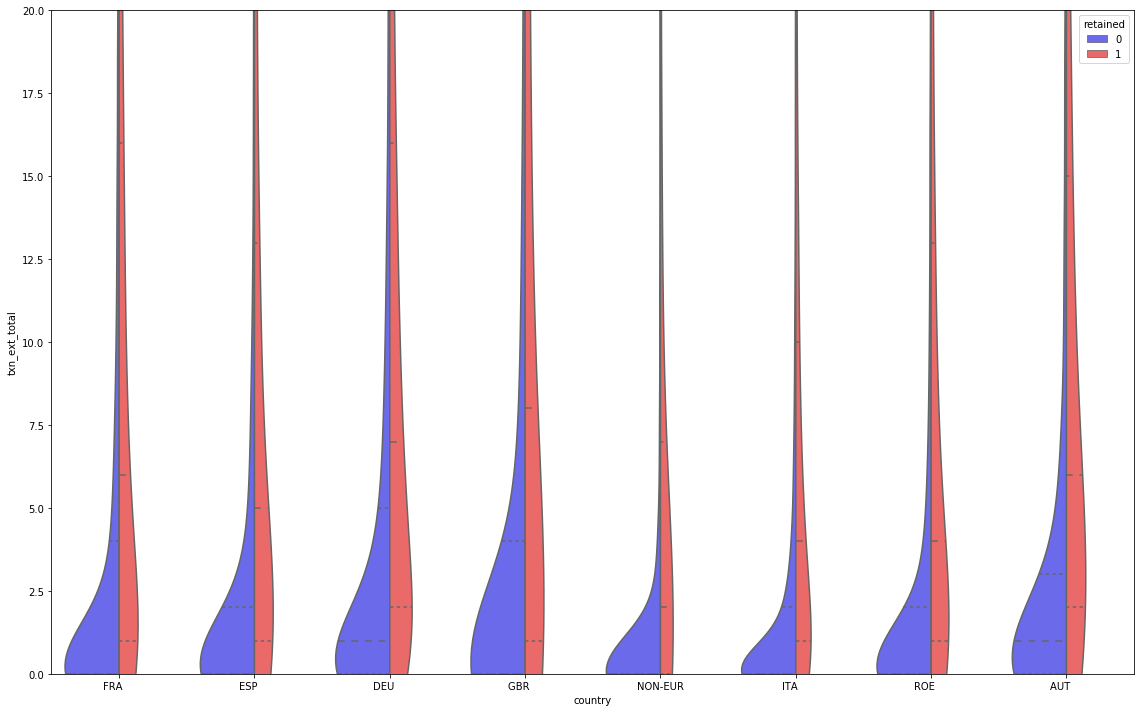

In [47]:
fig = plt.figure(figsize=(16, 10))
ax = sns.violinplot(
    x="country",
    y="txn_ext_total",
    data=df_1,
    scale="area",
    hue="retained",
    split=True,
    palette="seismic",
    inner="quartile",
    scale_hue=True,
    gridsize=1000,
)
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

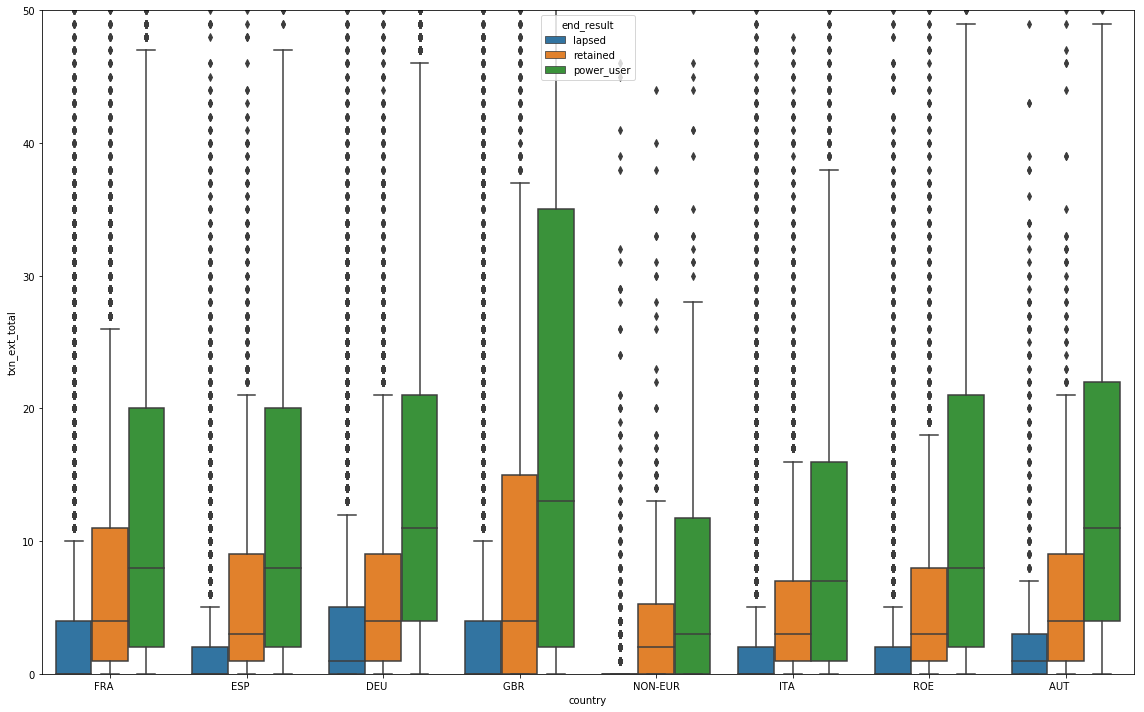

In [48]:
fig = plt.figure(figsize=(16, 10))
ax = sns.boxplot(x="country", y="txn_ext_total", data=df_1, hue="end_result")
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

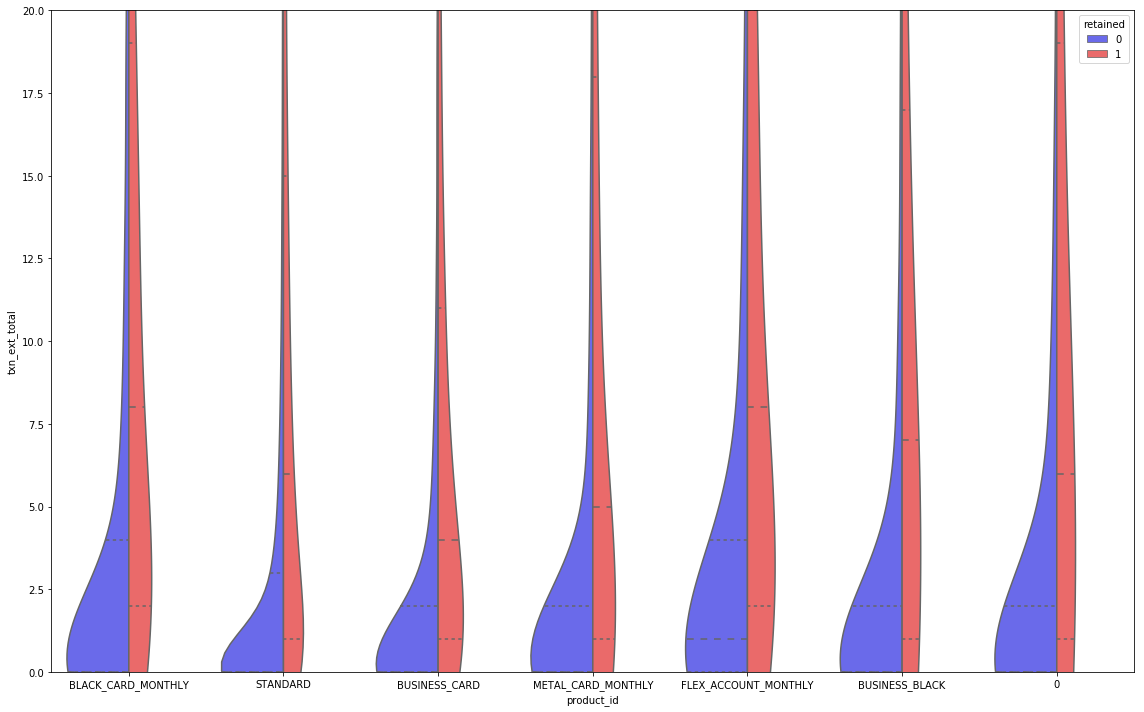

In [289]:
fig = plt.figure(figsize=(16, 10))
ax = sns.violinplot(
    x="product_id",
    y="txn_ext_total",
    data=df_1,
    scale="area",
    hue="retained",
    split=True,
    palette="seismic",
    inner="quartile",
    scale_hue=True,
    gridsize=1000,
)
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

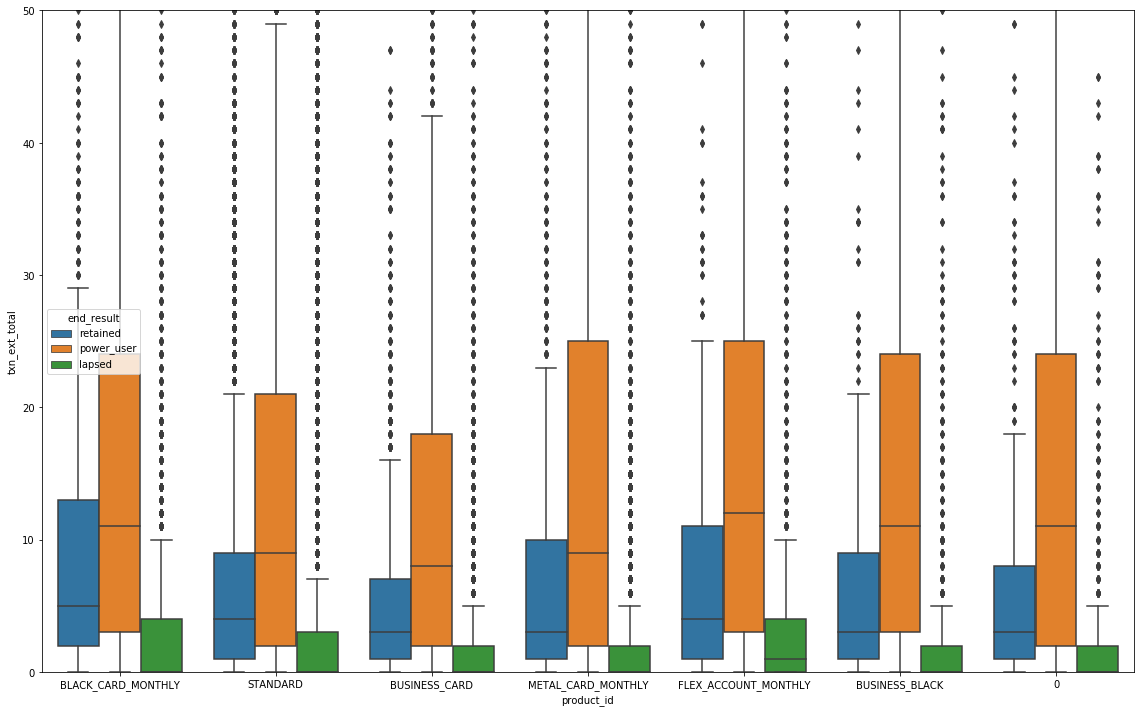

In [455]:
fig = plt.figure(figsize=(16, 10))
ax = sns.boxplot(x="product_id", y="txn_ext_total", data=df_1, hue="end_result")
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

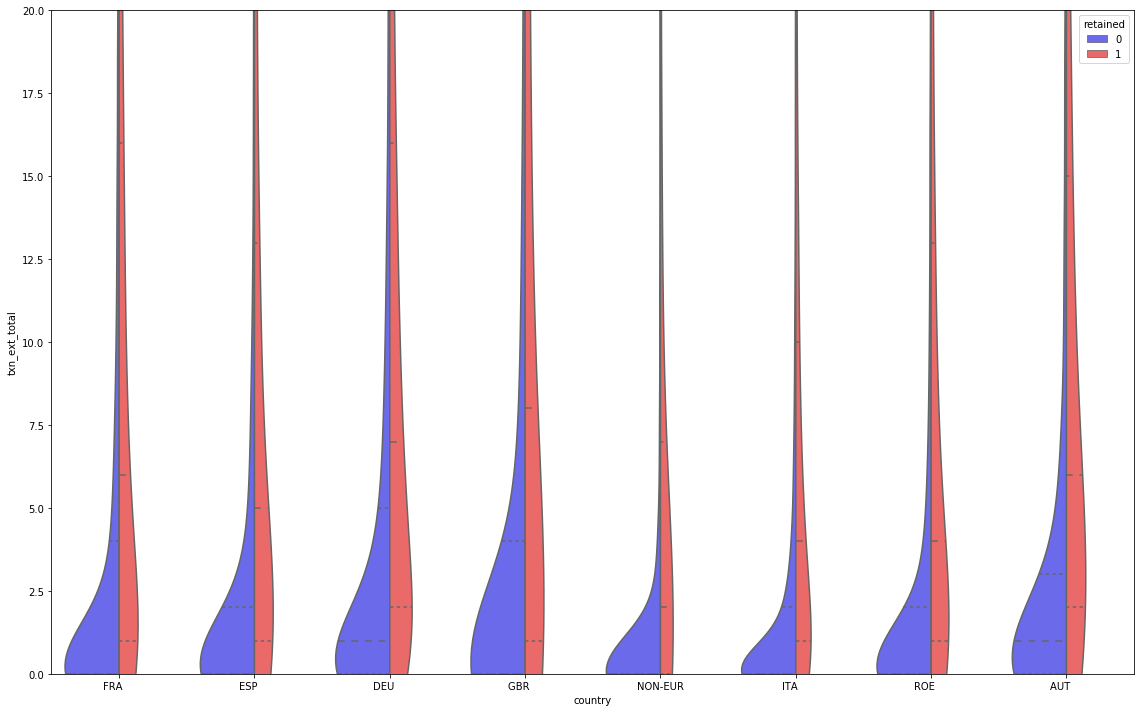

In [49]:
fig = plt.figure(figsize=(16, 10))
ax = sns.violinplot(
    x="country",
    y="txn_ext_total",
    data=df_1,
    scale="area",
    hue="retained",
    split=True,
    palette="seismic",
    inner="quartile",
    scale_hue=True,
    gridsize=1000,
)
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

Text(0, 0.5, '% KYCCs')

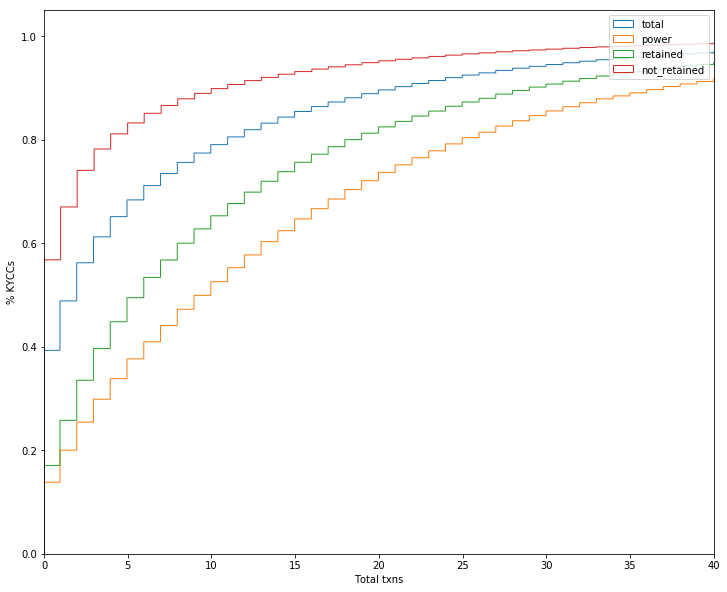

In [51]:
n_bins = 10000

fig, ax = plt.subplots(figsize=(12, 10))

# plot the cumulative histogram

n, bins, patches = ax.hist(
    df_1["txn_ext_total"],
    n_bins,
    density=True,
    histtype="step",
    cumulative=True,
    label="total",
)

n, bins, patches = ax.hist(
    df_1["txn_ext_total"][df_1["power_user"] == 1],
    n_bins,
    density=True,
    histtype="step",
    cumulative=True,
    label="power",
)

n, bins, patches = ax.hist(
    df_1["txn_ext_total"][df_1["retained"] == 1],
    n_bins,
    density=True,
    histtype="step",
    cumulative=True,
    label="retained",
)

n, bins, patches = ax.hist(
    df_1["txn_ext_total"][df_1["retained"] == 0],
    n_bins,
    density=True,
    histtype="step",
    cumulative=True,
    label="not_retained",
)

ax.legend()
plt.xlim((0, 40))
plt.xlabel("Total txns")
plt.ylabel("% KYCCs")

Text(0, 0.5, '% KYCCs')

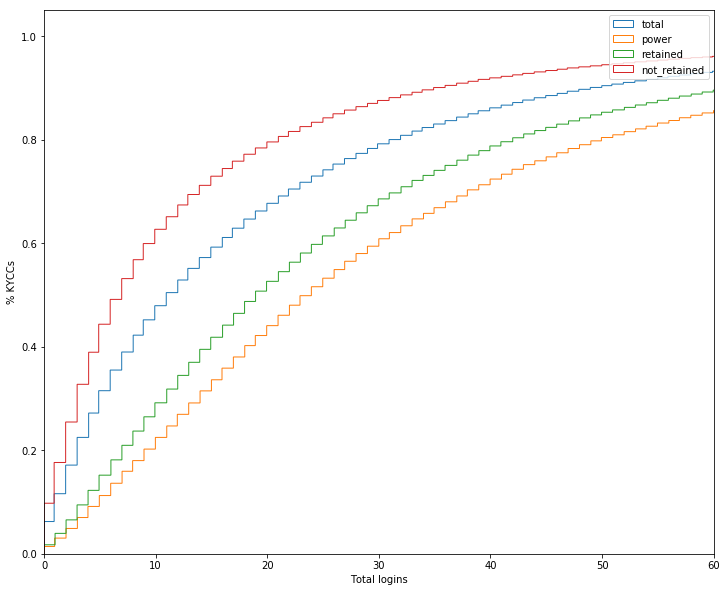

In [53]:
n_bins = 10000

fig, ax = plt.subplots(figsize=(12, 10))

# plot the cumulative histogram

n, bins, patches = ax.hist(
    df_1["login_total"],
    n_bins,
    density=True,
    histtype="step",
    cumulative=True,
    label="total",
)

n, bins, patches = ax.hist(
    df_1["login_total"][df_1["power_user"] == 1],
    n_bins,
    density=True,
    histtype="step",
    cumulative=True,
    label="power",
)

n, bins, patches = ax.hist(
    df_1["login_total"][df_1["retained"] == 1],
    n_bins,
    density=True,
    histtype="step",
    cumulative=True,
    label="retained",
)

n, bins, patches = ax.hist(
    df_1["login_total"][df_1["retained"] == 0],
    n_bins,
    density=True,
    histtype="step",
    cumulative=True,
    label="not_retained",
)

ax.legend()
plt.xlim((0, 60))
plt.xlabel("Total logins")
plt.ylabel("% KYCCs")

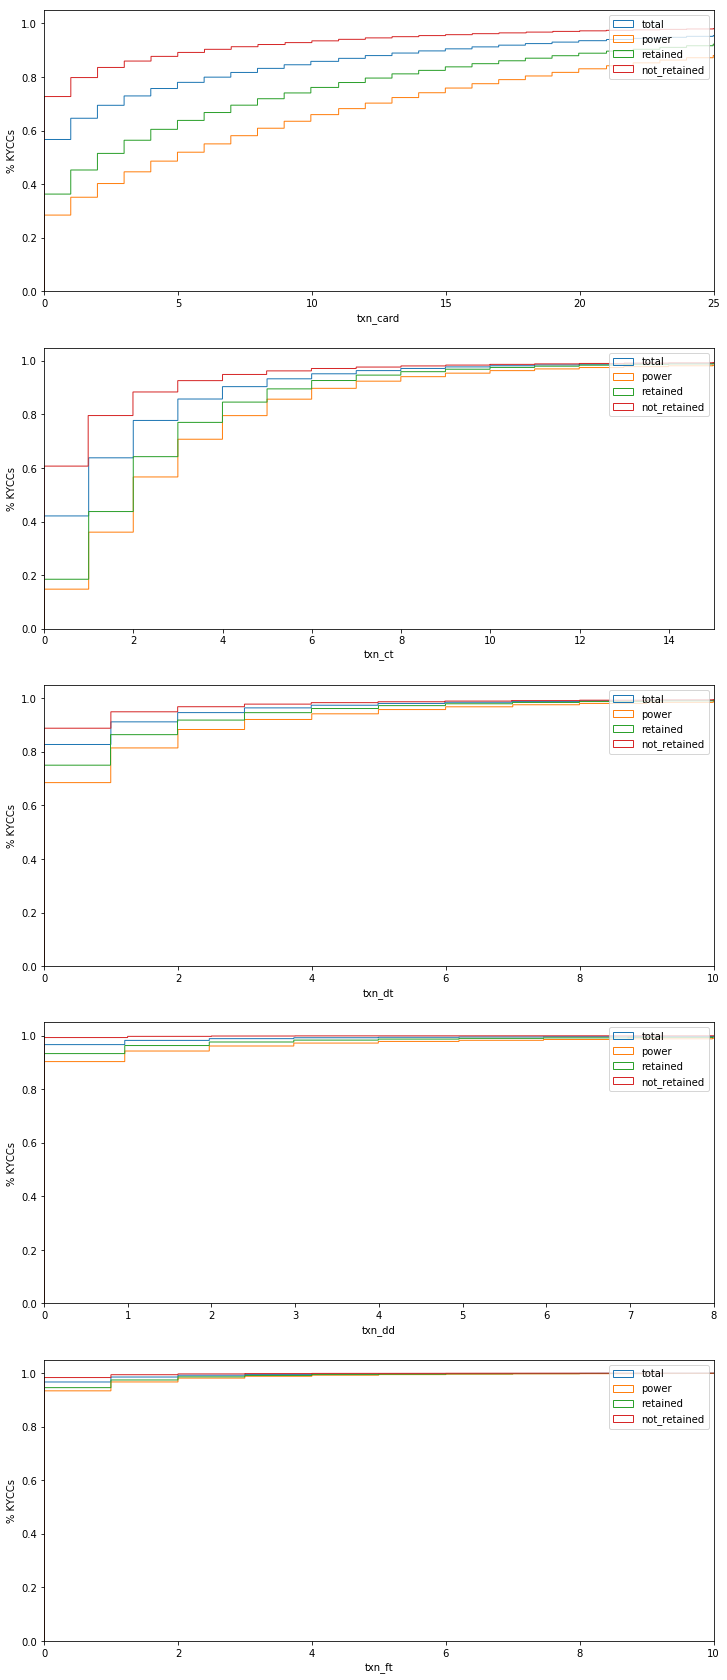

In [54]:
n_bins = 10000

txns_list = {"txn_card": 25, "txn_ct": 15, "txn_dt": 10, "txn_dd": 8, "txn_ft": 10}

fig, ax = plt.subplots(5, figsize=(12, 30))

# plot the cumulative histogram

for i, t in enumerate(txns_list):
    n, bins, patches = ax[i].hist(
        df_1[t], n_bins, density=True, histtype="step", cumulative=True, label="total"
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["power_user"] == 1],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="power",
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["retained"] == 1],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="retained",
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["retained"] == 0],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="not_retained",
    )

    ax[i].legend()
    ax[i].set_xlim((0, txns_list[t]))
    ax[i].set_xlabel(t)
    ax[i].set_ylabel("% KYCCs")

plt.show()

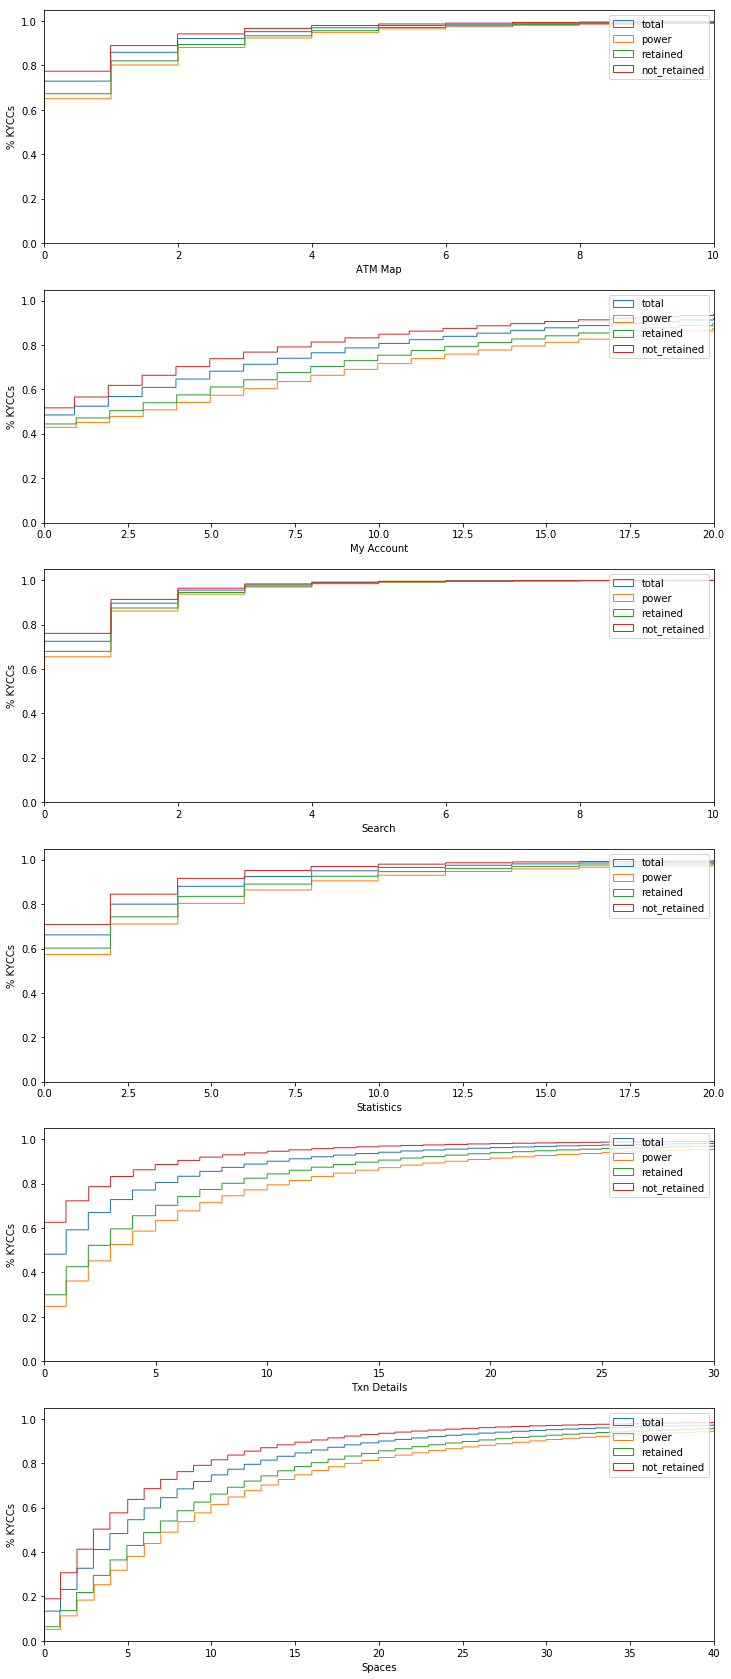

In [55]:
n_bins = 10000

event_list = {
    "ATM Map": 10,
    "My Account": 20,
    "Search": 10,
    "Statistics": 20,
    "Txn Details": 30,
    "Spaces": 40,
}

fig, ax = plt.subplots(len(event_list), figsize=(12, 30))

# plot the cumulative histogram

for i, t in enumerate(event_list):
    n, bins, patches = ax[i].hist(
        df_1[t], n_bins, density=True, histtype="step", cumulative=True, label="total"
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["power_user"] == 1],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="power",
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["retained"] == 1],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="retained",
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["retained"] == 0],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="not_retained",
    )

    ax[i].legend()
    ax[i].set_xlim((0, event_list[t]))
    ax[i].set_xlabel(t)
    ax[i].set_ylabel("% KYCCs")

plt.show()

In [56]:
len(txns_list)

5

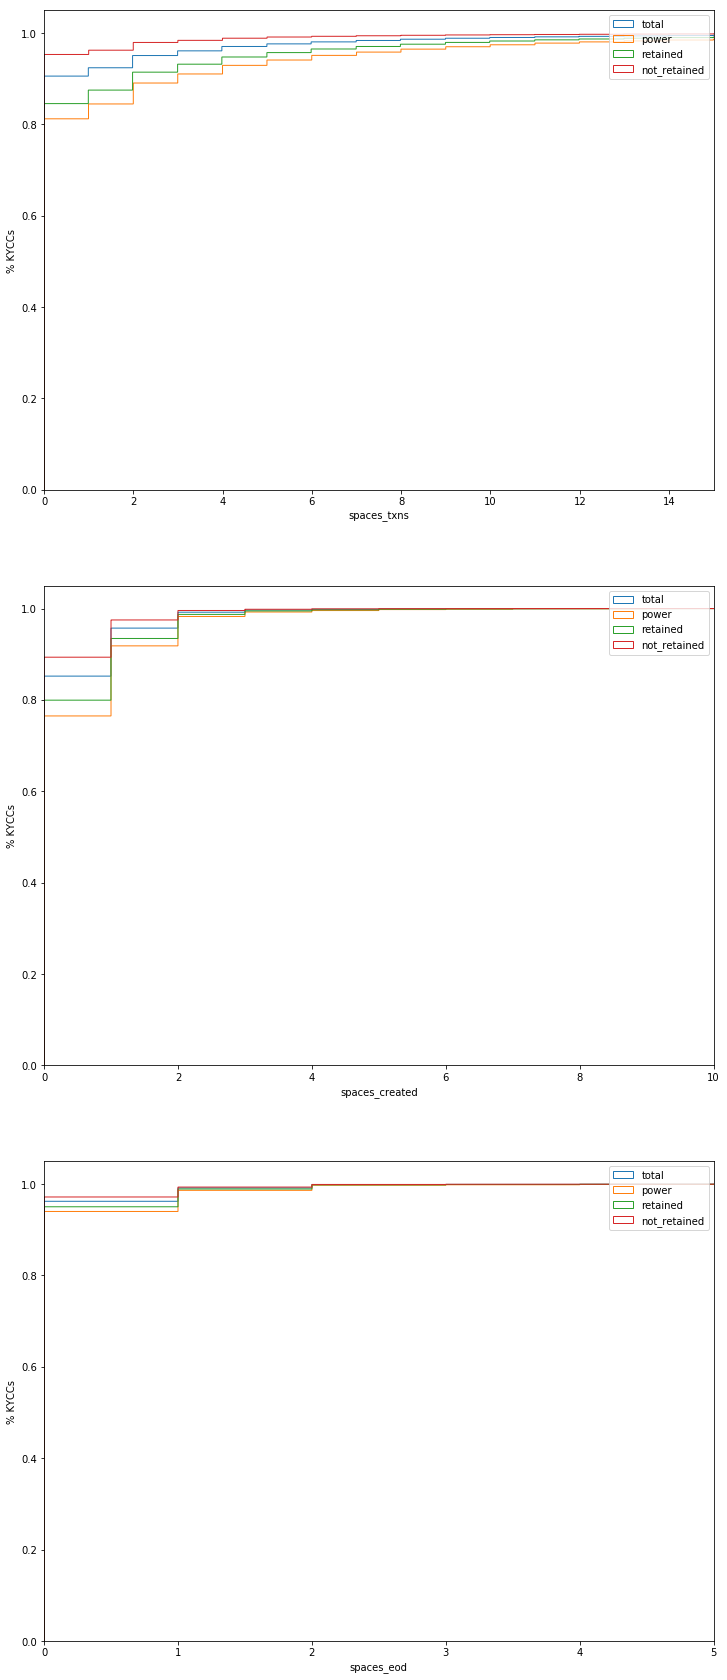

In [57]:
n_bins = 10000

event_list = {"spaces_txns": 15, "spaces_created": 10, "spaces_eod": 5}

fig, ax = plt.subplots(len(event_list), figsize=(12, 30))

# plot the cumulative histogram

for i, t in enumerate(event_list):
    n, bins, patches = ax[i].hist(
        df_1[t], n_bins, density=True, histtype="step", cumulative=True, label="total"
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["power_user"] == 1],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="power",
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["retained"] == 1],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="retained",
    )

    n, bins, patches = ax[i].hist(
        df_1[t][df_1["retained"] == 0],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="not_retained",
    )

    ax[i].legend()
    ax[i].set_xlim((0, event_list[t]))
    ax[i].set_xlabel(t)
    ax[i].set_ylabel("% KYCCs")

plt.show()

In [58]:
df_1["early_power_user"] = np.where(df_1["txn_ext_total"] >= 10, 1, 0)

In [59]:
df_1["end_result"] = "lapsed"
df_1["end_result"] = np.where(df_1["retained"] == 1, "retained", df_1["end_result"])
df_1["end_result"] = np.where(df_1["power_user"] == 1, "power_user", df_1["end_result"])

(0, 50)

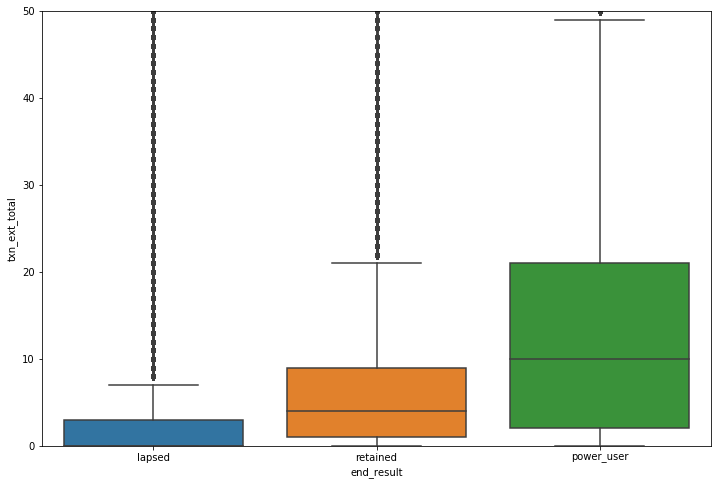

In [60]:
fig = plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="end_result", y="txn_ext_total", data=df_1)
plt.ylim(0, 50)

(0, 50)

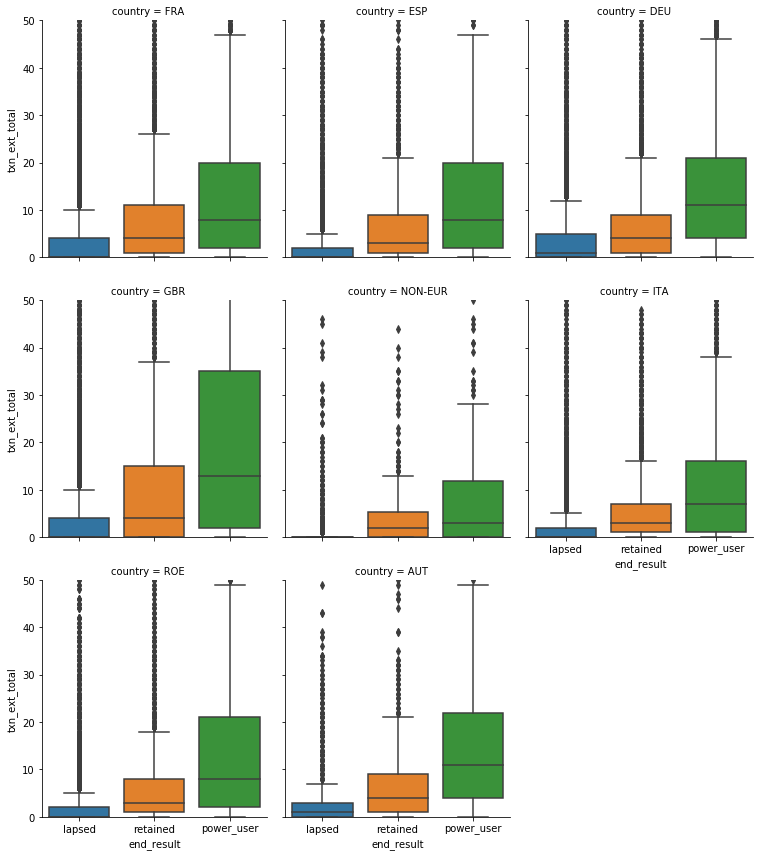

In [61]:
g = sns.catplot(
    x="end_result",
    y="txn_ext_total",
    col="country",
    data=df_1,
    kind="box",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

plt.ylim(0, 50)

(0, 50)

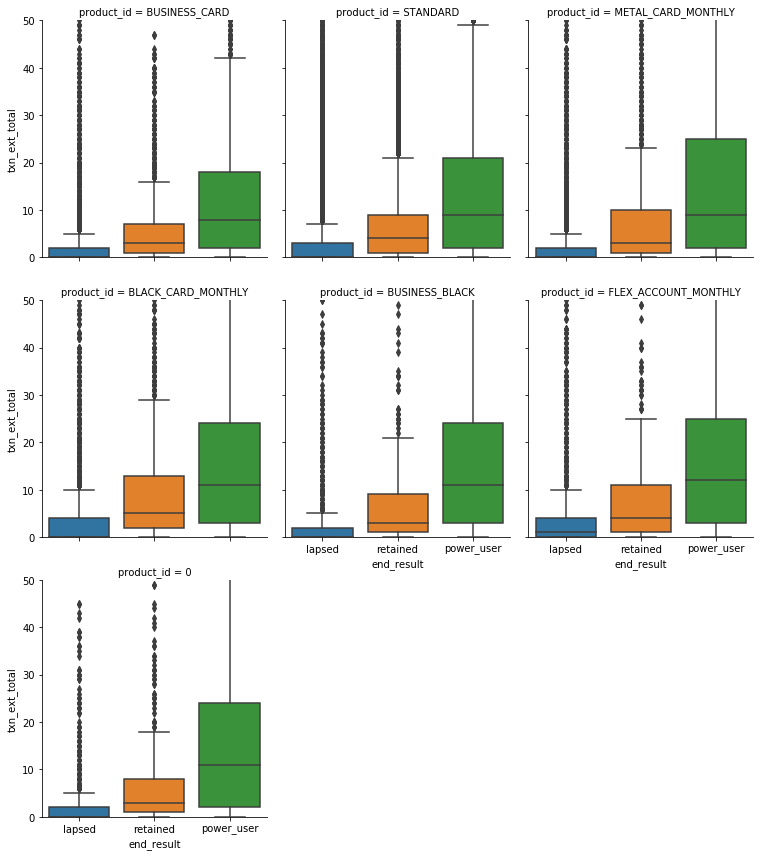

In [62]:
g = sns.catplot(
    x="end_result",
    y="txn_ext_total",
    col="product_id",
    data=df_1,
    kind="box",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

plt.ylim(0, 50)

(0, 50)

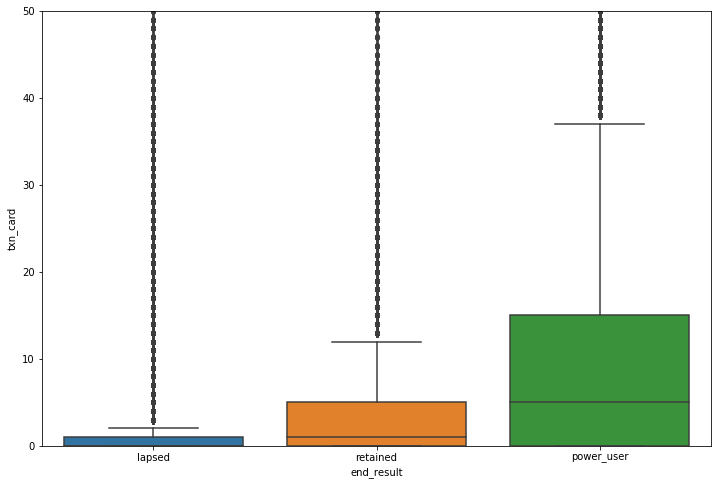

In [63]:
fig = plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="end_result", y="txn_card", data=df_1)
plt.ylim(0, 50)

(0, 50)

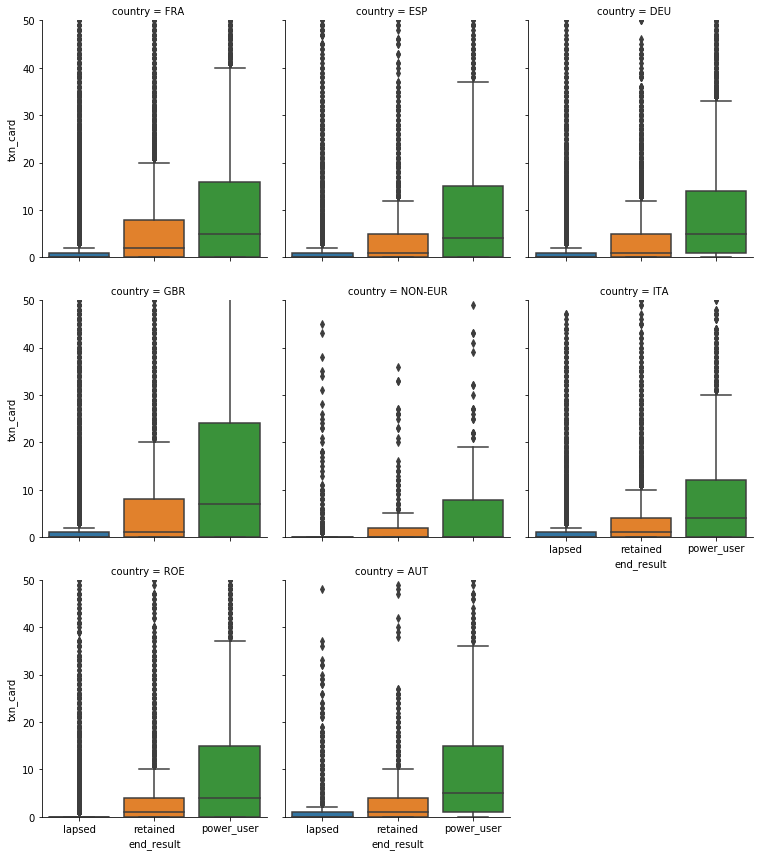

In [64]:
g = sns.catplot(
    x="end_result",
    y="txn_card",
    col="country",
    data=df_1,
    kind="box",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

plt.ylim(0, 50)

(0, 50)

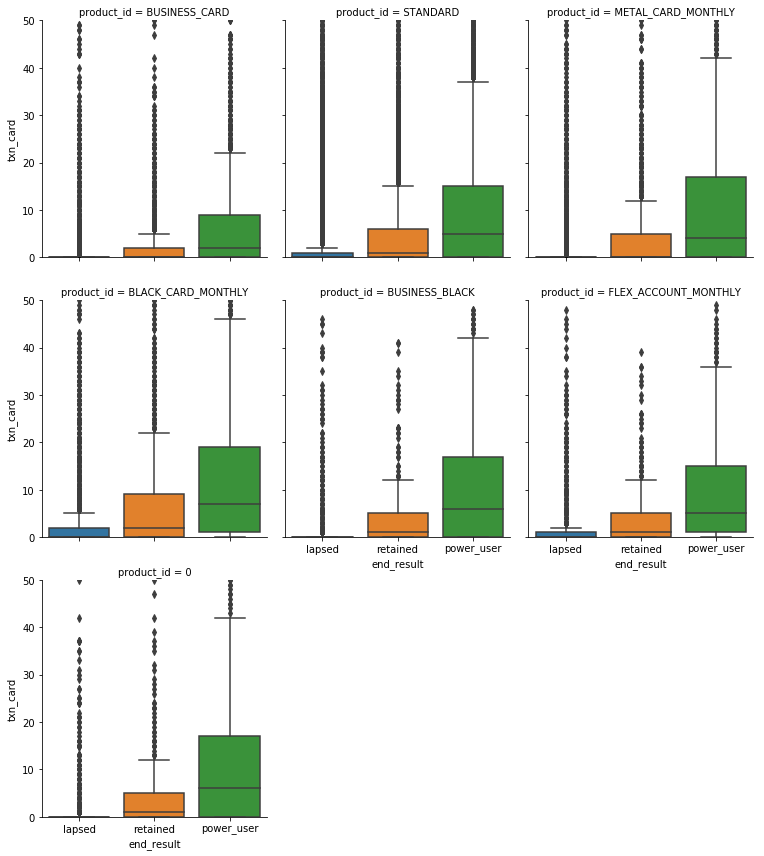

In [65]:
g = sns.catplot(
    x="end_result",
    y="txn_card",
    col="product_id",
    data=df_1,
    kind="box",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

plt.ylim(0, 50)

(0, 10)

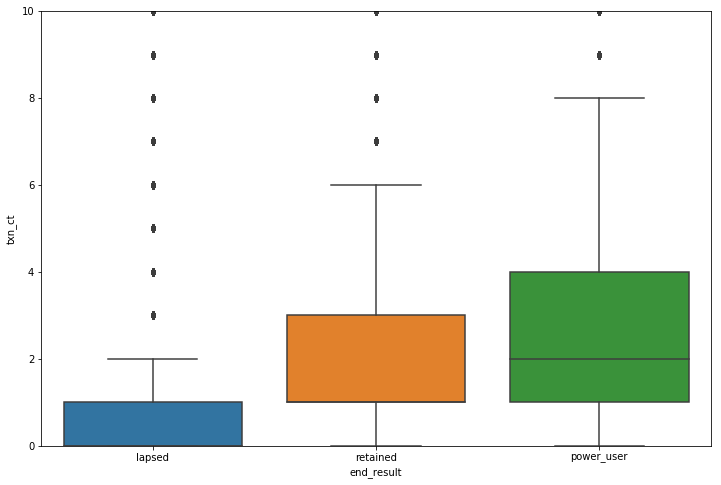

In [66]:
fig = plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="end_result", y="txn_ct", data=df_1)
plt.ylim(0, 10)

(0, 10)

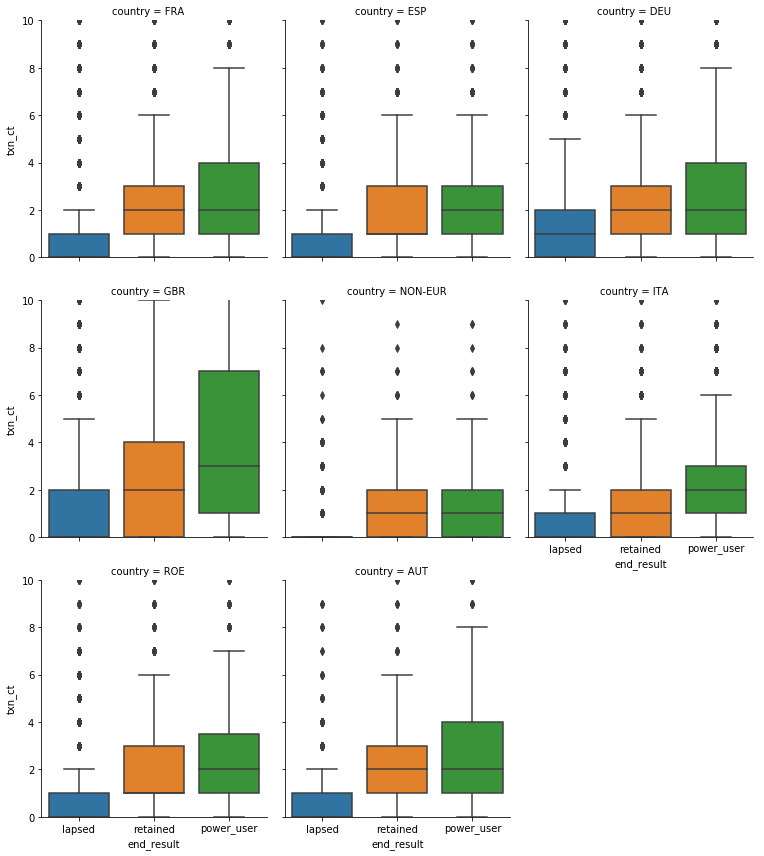

In [67]:
g = sns.catplot(
    x="end_result",
    y="txn_ct",
    col="country",
    data=df_1,
    kind="box",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

plt.ylim(0, 10)

(0, 10)

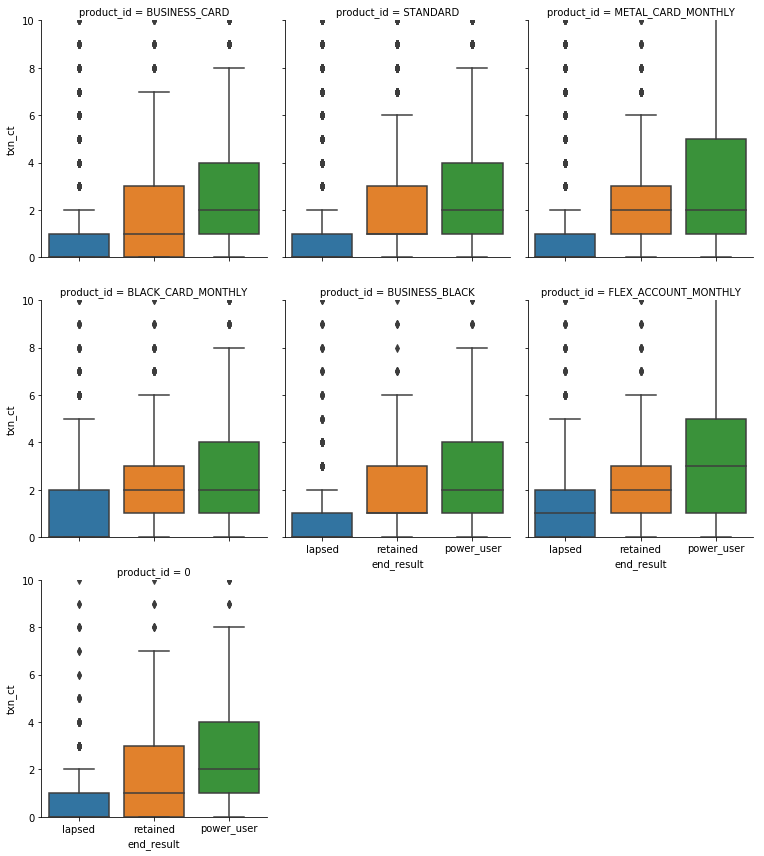

In [68]:
g = sns.catplot(
    x="end_result",
    y="txn_ct",
    col="product_id",
    data=df_1,
    kind="box",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

plt.ylim(0, 10)

(0, 100)

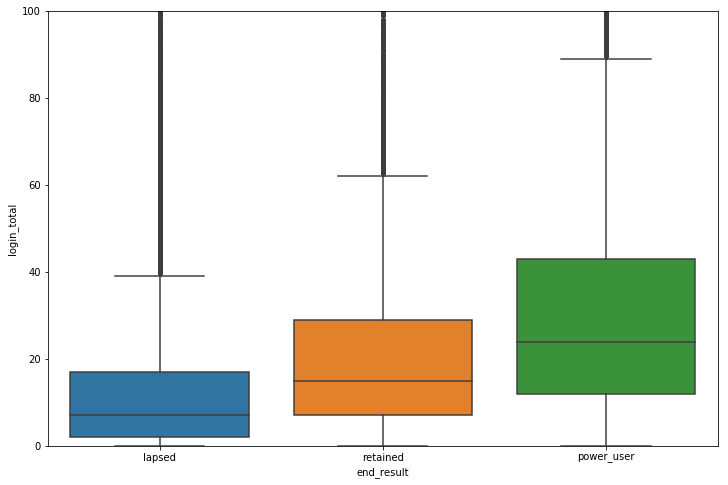

In [69]:
fig = plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="end_result", y="login_total", data=df_1)
plt.ylim(0, 100)

(0, 100)

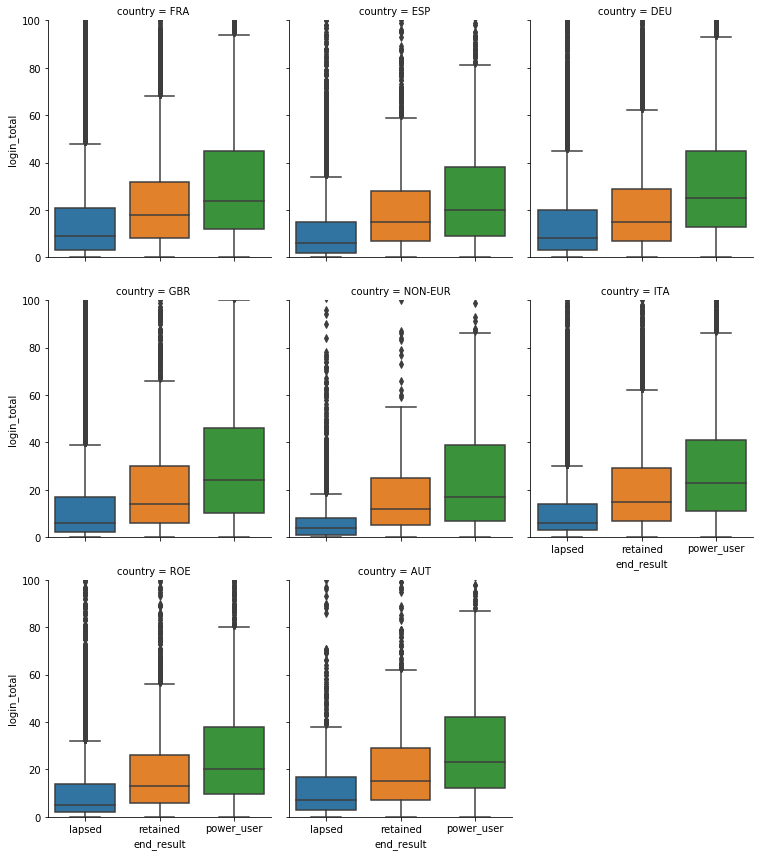

In [70]:
g = sns.catplot(
    x="end_result",
    y="login_total",
    col="country",
    data=df_1,
    kind="box",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

plt.ylim(0, 100)

(0, 100)

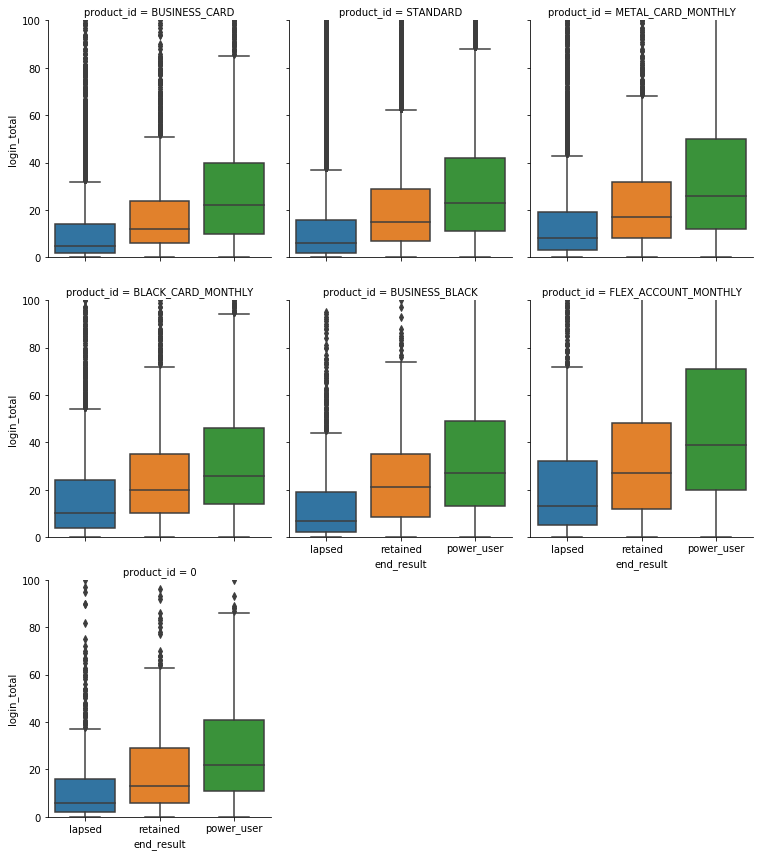

In [71]:
g = sns.catplot(
    x="end_result",
    y="login_total",
    col="product_id",
    data=df_1,
    kind="box",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

plt.ylim(0, 100)

In [72]:
event_list = ["ATM Map", "My Account", "Search", "Statistics", "Txn Details", "Spaces"]

In [73]:
for c in event_list:
    c_name = c + "_ps"
    df_1[c_name] = np.where(df_1["login_total"] == 0, 0, df_1[c] / df_1["login_total"])

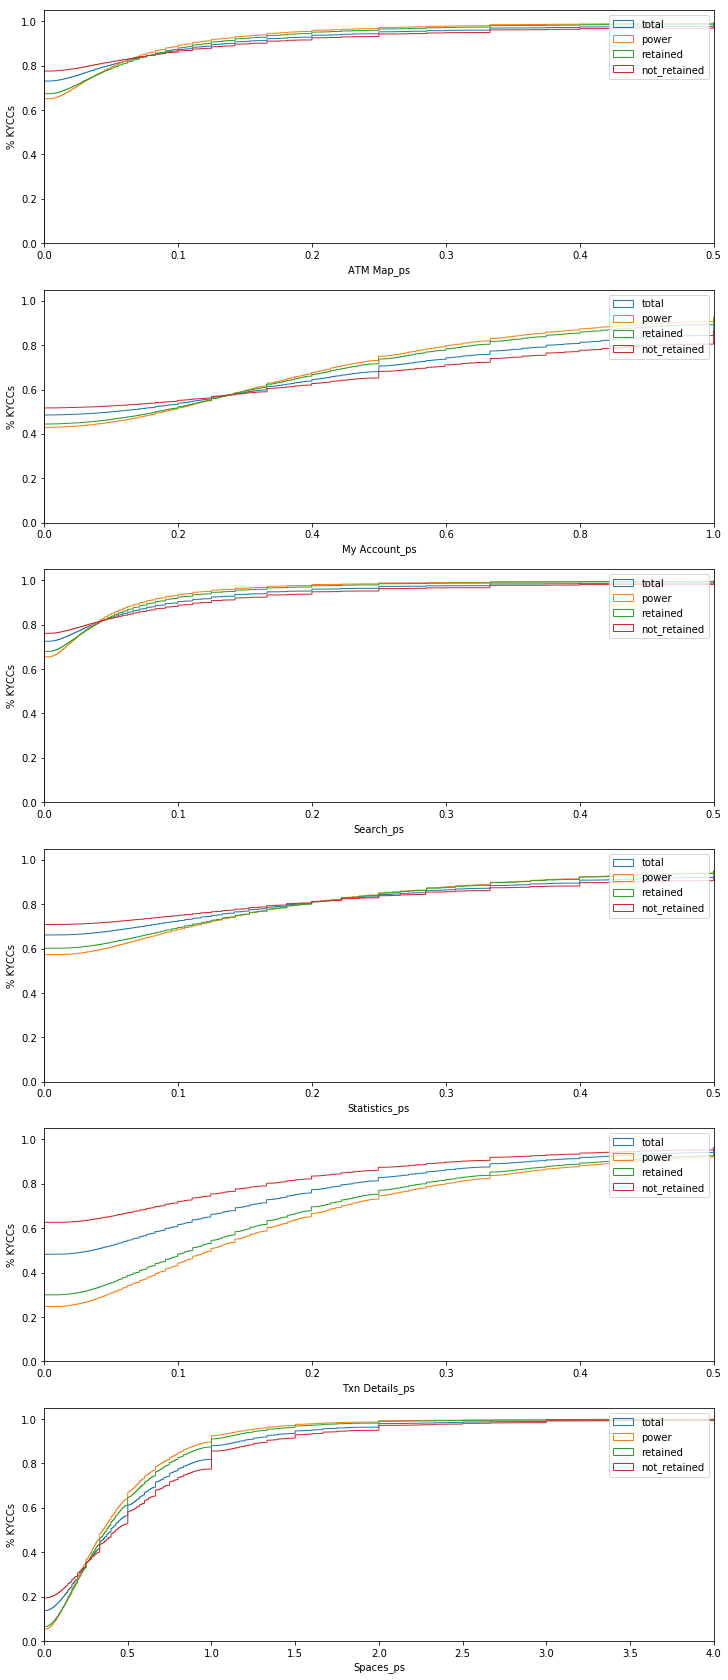

In [74]:
n_bins = 10000

event_list = {
    "ATM Map_ps": 0.5,
    "My Account_ps": 1,
    "Search_ps": 0.5,
    "Statistics_ps": 0.5,
    "Txn Details_ps": 0.5,
    "Spaces_ps": 4,
}

fig, ax = plt.subplots(len(event_list), figsize=(12, 30))

# plot the cumulative histogram

for i, t in enumerate(event_list):
    df_plot = df_1[np.isfinite(df_1[t])]

    n, bins, patches = ax[i].hist(
        df_plot[t],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="total",
    )

    n, bins, patches = ax[i].hist(
        df_plot[t][df_plot["power_user"] == 1],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="power",
    )

    n, bins, patches = ax[i].hist(
        df_plot[t][df_plot["retained"] == 1],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="retained",
    )

    n, bins, patches = ax[i].hist(
        df_plot[t][df_plot["retained"] == 0],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label="not_retained",
    )

    ax[i].legend()
    ax[i].set_xlim((0, event_list[t]))
    ax[i].set_xlabel(t)
    ax[i].set_ylabel("% KYCCs")

plt.show()

In [75]:
df_e_ret = pd.merge(
    df, df_1[["user_created", "end_result"]], on=["user_created"], how="left"
)

In [76]:
df_e_ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793128 entries, 0 to 793127
Data columns (total 37 columns):
user_created      793128 non-null datetime64[ns]
kyc_c             793128 non-null datetime64[ns]
country           793128 non-null object
product_id        793128 non-null object
cohort            793128 non-null datetime64[ns]
diff              793128 non-null int64
txn_card          793128 non-null float64
txn_ct            793128 non-null float64
txn_dt            793128 non-null float64
txn_dd            793128 non-null float64
txn_ft            793128 non-null float64
txn_ext_total     793128 non-null float64
login_total       793128 non-null float64
login_web         793128 non-null float64
spaces_eod        793128 non-null float64
spaces_created    793128 non-null float64
spaces_deleted    793128 non-null float64
ATM Map           793128 non-null float64
Bal. Check        793128 non-null float64
Bal. Discreet     793128 non-null float64
Cash26            793128 non-nul

In [77]:
event_list = ["ATM Map", "My Account", "Search", "Statistics", "Txn Details", "Spaces"]
result = []
for e in event_list:
    e_name = e + "_first"
    df_e_plot = pd.merge(
        df_e_ret, df_1["user_created"][df_1[e] > 0], on="user_created", how="inner"
    )
    df_e_plot[e_name] = np.where(df_e_plot[e] > 0, 1, 0)
    result.append(df_e_plot.groupby(["diff", "end_result"])[e_name].sum())

df_r = pd.DataFrame(result)

df_r.reset_index(inplace=True)

df_r = pd.melt(df_r, id_vars="index")

df_r["max_value"] = df_r.groupby(["index", "end_result"])["value"].transform(max)
df_r["perc_retained"] = df_r["value"] / df_r["max_value"]

In [78]:
df_r.head()

,index,diff,end_result,value,max_value,perc_retained
0,ATM Map_first,1,lapsed,16698,16698,1.0
1,My Account_first,1,lapsed,35756,35756,1.0
2,Search_first,1,lapsed,17742,17742,1.0
3,Statistics_first,1,lapsed,21551,21551,1.0
4,Txn Details_first,1,lapsed,27665,27665,1.0


In [79]:
df_r.head()

,index,diff,end_result,value,max_value,perc_retained
0,ATM Map_first,1,lapsed,16698,16698,1.0
1,My Account_first,1,lapsed,35756,35756,1.0
2,Search_first,1,lapsed,17742,17742,1.0
3,Statistics_first,1,lapsed,21551,21551,1.0
4,Txn Details_first,1,lapsed,27665,27665,1.0


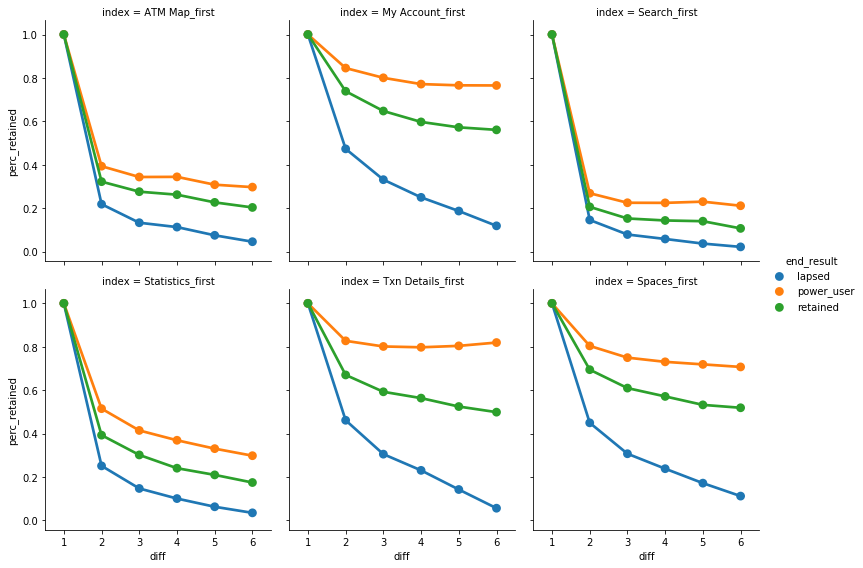

In [80]:
g = sns.catplot(
    x="diff",
    y="perc_retained",
    col="index",
    hue="end_result",
    data=df_r,
    kind="point",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

In [81]:
event_list = ["txn_card", "txn_ct", "txn_dt", "txn_dd", "txn_ft"]
result = []
for e in event_list:
    e_name = e + "_first"
    df_e_plot = pd.merge(
        df_e_ret, df_1["user_created"][df_1[e] > 0], on="user_created", how="inner"
    )
    df_e_plot[e_name] = np.where(df_e_plot[e] > 0, 1, 0)
    result.append(df_e_plot.groupby(["diff", "end_result"])[e_name].sum())

df_r = pd.DataFrame(result)

df_r.reset_index(inplace=True)

df_r = pd.melt(df_r, id_vars="index")

df_r["max_value"] = df_r.groupby(["index", "end_result"])["value"].transform(max)
df_r["perc_retained"] = df_r["value"] / df_r["max_value"]

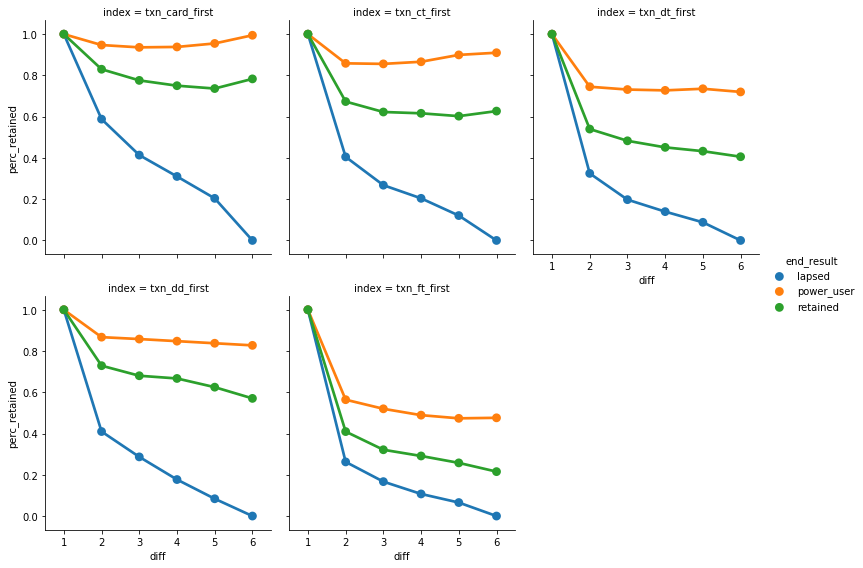

In [82]:
g = sns.catplot(
    x="diff",
    y="perc_retained",
    col="index",
    hue="end_result",
    data=df_r,
    kind="point",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

In [83]:
event_list = ["spaces_created", "spaces_txns"]
result = []
for e in event_list:
    e_name = e + "_first"
    df_e_plot = pd.merge(
        df_e_ret, df_1["user_created"][df_1[e] > 0], on="user_created", how="inner"
    )
    df_e_plot[e_name] = np.where(df_e_plot[e] > 0, 1, 0)
    result.append(df_e_plot.groupby(["diff", "end_result"])[e_name].sum())

df_r = pd.DataFrame(result)

df_r.reset_index(inplace=True)

df_r = pd.melt(df_r, id_vars="index")

df_r["max_value"] = df_r.groupby(["index", "end_result"])["value"].transform(max)
df_r["perc_retained"] = df_r["value"] / df_r["max_value"]

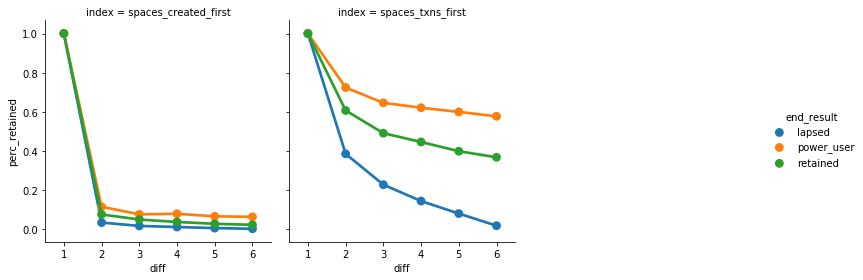

In [84]:
g = sns.catplot(
    x="diff",
    y="perc_retained",
    col="index",
    hue="end_result",
    data=df_r,
    kind="point",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

In [85]:
event_list = ["login_total", "login_web"]
result = []
for e in event_list:
    e_name = e + "_first"
    df_e_plot = pd.merge(
        df_e_ret, df_1["user_created"][df_1[e] > 0], on="user_created", how="inner"
    )
    df_e_plot[e_name] = np.where(df_e_plot[e] > 0, 1, 0)
    result.append(df_e_plot.groupby(["diff", "end_result"])[e_name].sum())

df_r = pd.DataFrame(result)

df_r.reset_index(inplace=True)

df_r = pd.melt(df_r, id_vars="index")

df_r["max_value"] = df_r.groupby(["index", "end_result"])["value"].transform(max)
df_r["perc_retained"] = df_r["value"] / df_r["max_value"]

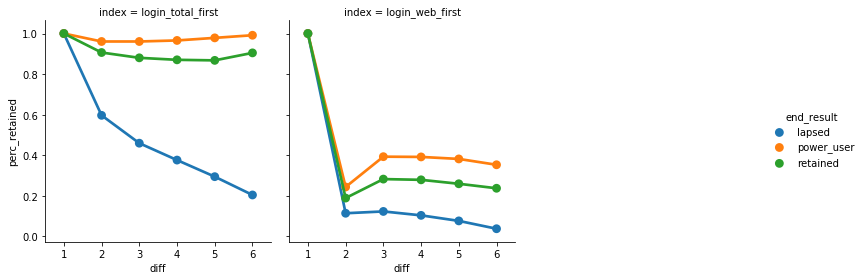

In [86]:
g = sns.catplot(
    x="diff",
    y="perc_retained",
    col="index",
    hue="end_result",
    data=df_r,
    kind="point",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

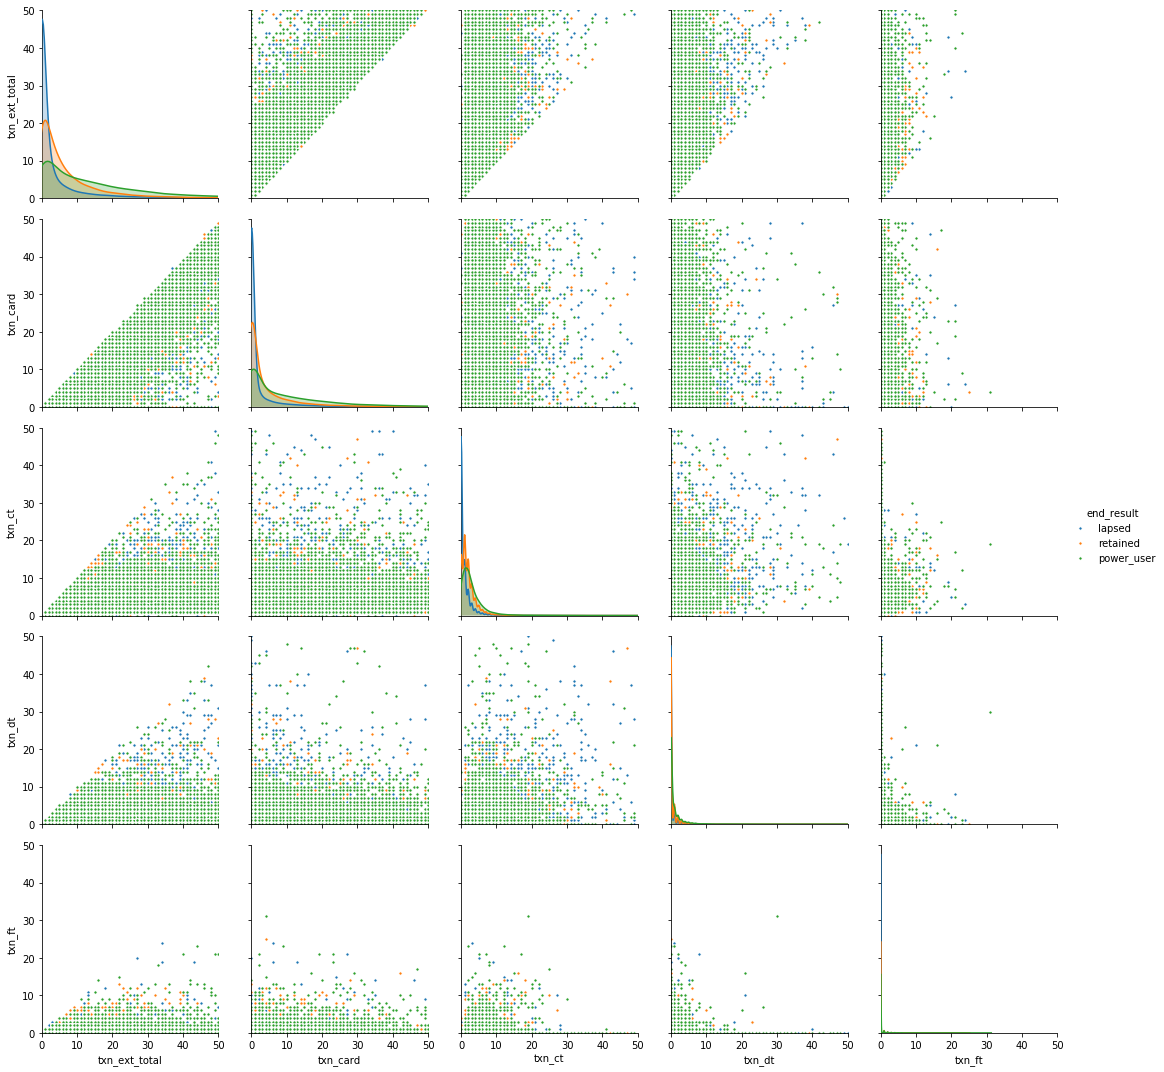

In [112]:
g = sns.pairplot(
    df_1,
    height=3,
    hue="end_result",
    vars=["txn_ext_total", "txn_card", "txn_ct", "txn_dt", "txn_ft"],
    diag_kind="kde",
    plot_kws=dict(s=10),
    diag_kws=dict(gridsize=1000),
)
g.set(xlim=(0, 50), ylim=(0, 50))

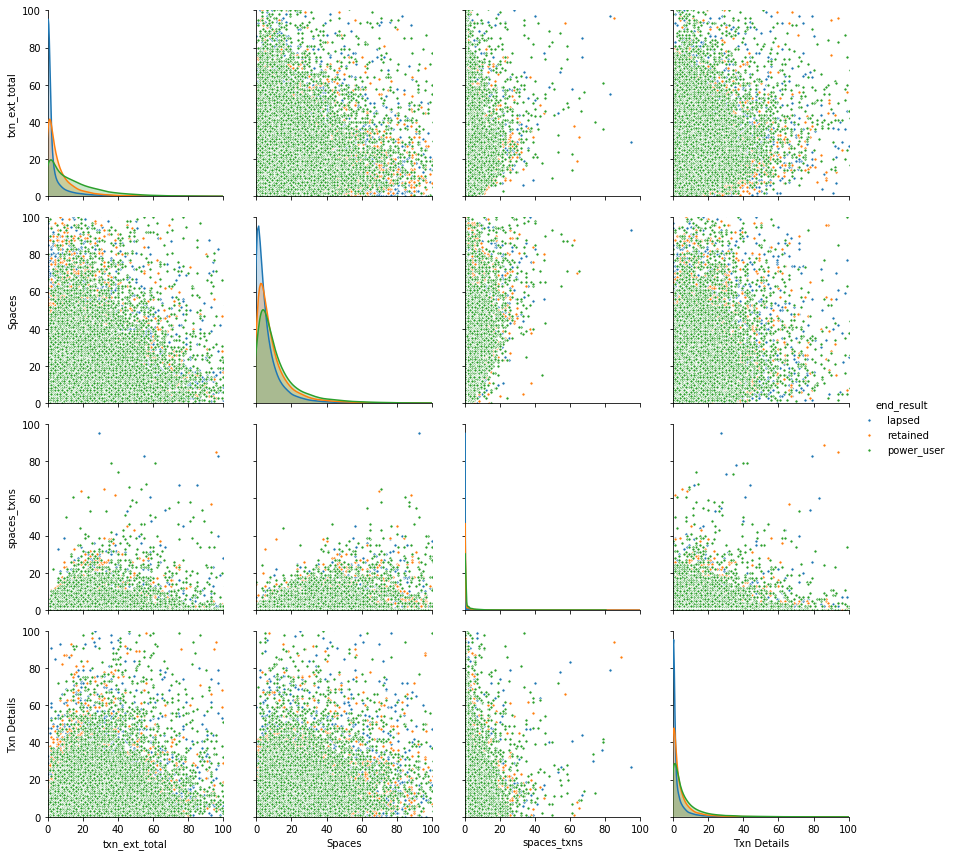

In [116]:
g = sns.pairplot(
    df_1,
    height=3,
    hue="end_result",
    vars=["txn_ext_total", "Spaces", "spaces_txns", "Txn Details"],
    diag_kind="kde",
    plot_kws=dict(s=10),
    diag_kws=dict(gridsize=1000),
)
g.set(xlim=(0, 100), ylim=(0, 100))

#### Feature retention: Lets look at feature retention for groups of users who become more active and less active over time --> is there a relative difference between the two?

In [129]:
df_1 = pd.merge(
    df_1,
    df_6[["user_created", "txn_ext_total"]],
    how="left",
    on="user_created",
    suffixes=("", "_6"),
)

In [138]:
df_e_ret.head()

,user_created,kyc_c,country,product_id,cohort,diff,txn_card,txn_ct,txn_dt,txn_dd,...,My Account,Request,Savings,Search,Spaces,Statistics,Txn Details,other,spaces_txns,journey
0,2017-10-12 09:07:26.011435,2019-01-11 14:52:08.381,FRA,BUSINESS_CARD,2019-01-01,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0-0
1,2017-10-12 09:07:26.011435,2019-01-11 14:52:08.381,FRA,BUSINESS_CARD,2019-01-01,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0-0
2,2017-10-12 09:07:26.011435,2019-01-11 14:52:08.381,FRA,BUSINESS_CARD,2019-01-01,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0-0
3,2017-10-12 09:07:26.011435,2019-01-11 14:52:08.381,FRA,BUSINESS_CARD,2019-01-01,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0-0
4,2017-10-12 09:07:26.011435,2019-01-11 14:52:08.381,FRA,BUSINESS_CARD,2019-01-01,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0-0


In [139]:
df_1["early_group"] = np.where(df_1["txn_ext_total"] >= 1, "1", "0")
# df_1['early_group'] = np.where(df_1['txn_ext_total']>=5,'5',df_1['early_group'])
df_1["early_group"] = np.where(df_1["txn_ext_total"] >= 10, "10", df_1["early_group"])


df_1["late_group"] = np.where(df_1["txn_ext_total_6"] >= 1, "1", "0")
# df_1['late_group'] = np.where(df_1['txn_ext_total_6']>=5,'5',df_1['late_group'])
df_1["late_group"] = np.where(df_1["txn_ext_total_6"] >= 10, "10", df_1["late_group"])

df_1["journey"] = df_1["early_group"] + "-" + df_1["late_group"]

In [140]:
df_e_ret = pd.merge(
    df, df_1[["user_created", "journey"]], on=["user_created"], how="left"
)

In [141]:
event_list = ["txn_card", "txn_ct", "txn_dt", "txn_dd", "txn_ft"]
result = []
for e in event_list:
    e_name = e + "_first"
    df_e_plot = pd.merge(
        df_e_ret, df_1["user_created"][df_1[e] > 0], on="user_created", how="inner"
    )
    df_e_plot[e_name] = np.where(df_e_plot[e] > 0, 1, 0)
    result.append(df_e_plot.groupby(["diff", "journey"])[e_name].sum())

df_r = pd.DataFrame(result)

df_r.reset_index(inplace=True)

df_r = pd.melt(df_r, id_vars="index")

df_r["max_value"] = df_r.groupby(["index", "journey"])["value"].transform(max)
df_r["perc_retained"] = df_r["value"] / df_r["max_value"]

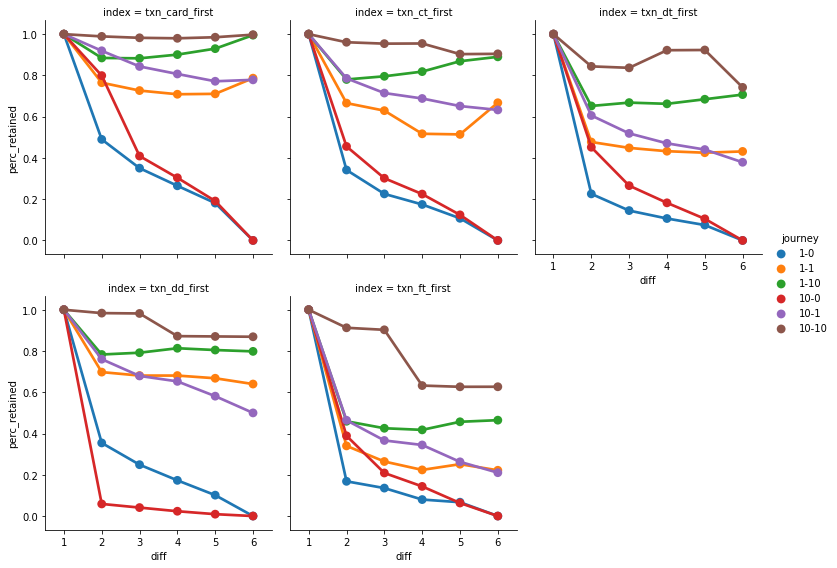

In [142]:
g = sns.catplot(
    x="diff",
    y="perc_retained",
    col="index",
    hue="journey",
    data=df_r,
    kind="point",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

In [143]:
event_list = ["ATM Map", "My Account", "Search", "Statistics", "Txn Details", "Spaces"]
result = []
for e in event_list:
    e_name = e + "_first"
    df_e_plot = pd.merge(
        df_e_ret, df_1["user_created"][df_1[e] > 0], on="user_created", how="inner"
    )
    df_e_plot[e_name] = np.where(df_e_plot[e] > 0, 1, 0)
    result.append(df_e_plot.groupby(["diff", "journey"])[e_name].sum())

df_r = pd.DataFrame(result)

df_r.reset_index(inplace=True)

df_r = pd.melt(df_r, id_vars="index")

df_r["max_value"] = df_r.groupby(["index", "journey"])["value"].transform(max)
df_r["perc_retained"] = df_r["value"] / df_r["max_value"]

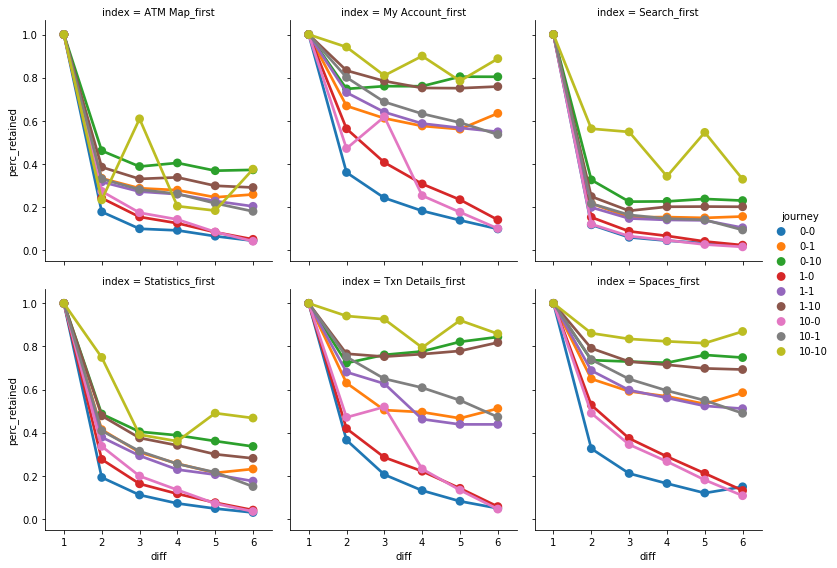

In [144]:
g = sns.catplot(
    x="diff",
    y="perc_retained",
    col="index",
    hue="journey",
    data=df_r,
    kind="point",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

In [145]:
event_list = ["spaces_created", "spaces_txns"]
result = []
for e in event_list:
    e_name = e + "_first"
    df_e_plot = pd.merge(
        df_e_ret, df_1["user_created"][df_1[e] > 0], on="user_created", how="inner"
    )
    df_e_plot[e_name] = np.where(df_e_plot[e] > 0, 1, 0)
    result.append(df_e_plot.groupby(["diff", "journey"])[e_name].sum())

df_r = pd.DataFrame(result)

df_r.reset_index(inplace=True)

df_r = pd.melt(df_r, id_vars="index")

df_r["max_value"] = df_r.groupby(["index", "journey"])["value"].transform(max)
df_r["perc_retained"] = df_r["value"] / df_r["max_value"]

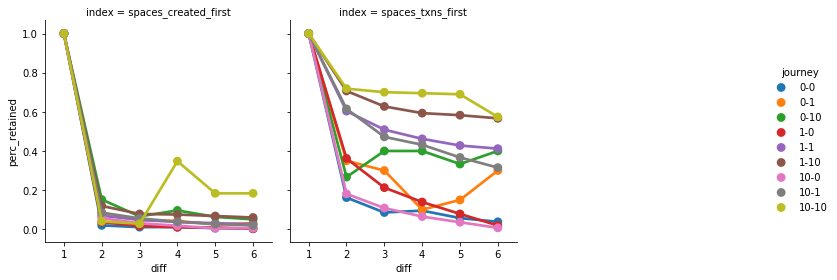

In [146]:
g = sns.catplot(
    x="diff",
    y="perc_retained",
    col="index",
    hue="journey",
    data=df_r,
    kind="point",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

In [244]:
df_e_ret["journey_count"] = df_e_ret.groupby(["journey", "diff"])[
    "user_created"
].transform(len)

In [245]:
e_list = [
    "spaces_created",
    "spaces_txns",
    "ATM Map",
    "My Account",
    "Search",
    "Statistics",
    "Txn Details",
    "Spaces",
    "txn_card",
    "txn_ct",
    "txn_dt",
    "txn_dd",
    "txn_ft",
    "txn_ext_total",
]

e_list_2 = []

for e in e_list:
    e_name = e + "_first"
    df_e_ret[e_name] = np.where(df_e_ret[e] > 0, 1, 0)
    e_list_2.append(e_name)

df_e_ret_grp = df_e_ret.groupby(["journey", "diff"])[e_list_2].sum()

In [246]:
df_e_ret_grp.head()

spaces_created_first  spaces_txns_first  ATM Map_first  \
journey diff                                                           
0-0     1                     2760                105           7228   
        2                      677                309           2502   
        3                      357                301           1928   
        4                      238                252           1895   
        5                      159                135           1448   

              My Account_first  Search_first  Statistics_first  \
journey diff                                                     
0-0     1                18160          7267              9165   
        2                10144          2496              3757   
        3                 8135          1438              2486   
        4                 6173          1071              1657   
        5                 4712           785              1116   

              Txn Details_first  Spaces_first  txn_card_first  txn_ct_first  \
journey diff                                                                  
0-0     1                  3155         29949               0             0   
        2                  4590         12272            2884          4490   
        3                  3530          8012            2960          2977   
        4                  2844          6230            2451          2236   
        5                  1894          4629            1700          1418   

              txn_dt_first  txn_dd_first  txn_ft_first  txn_ext_total_first  
journey diff                                                                 
0-0     1                0             0             0                    0  
        2              993            42           109                 5023  
        3              939            46           103                 4298  
        4              750            49            74                 3559  
        5              539            36            54                 2538

In [247]:
df_e_ret_grp.reset_index(inplace=True)
df_e_ret_grp = df_e_ret_grp.melt(id_vars=["journey", "diff"])
df_e_ret_grp = pd.merge(
    df_e_ret_grp, df_e_ret_grp_users, on=["journey", "diff"], how="inner"
)
df_e_ret_grp["perc_usage"] = df_e_ret_grp["value"] / df_e_ret_grp["user_created"]

In [248]:
df_e_ret_grp

,journey,diff,variable,value,user_created,perc_usage
0,0-0,1,spaces_created_first,2760,42231,0.065355
1,0-0,1,spaces_txns_first,105,42231,0.002486
2,0-0,1,ATM Map_first,7228,42231,0.171154
3,0-0,1,My Account_first,18160,42231,0.430016
4,0-0,1,Search_first,7267,42231,0.172077
5,0-0,1,Statistics_first,9165,42231,0.217021
6,0-0,1,Txn Details_first,3155,42231,0.074708
7,0-0,1,Spaces_first,29949,42231,0.709171
8,0-0,1,txn_card_first,0,42231,0.000000
9,0-0,1,txn_ct_first,0,42231,0.000000


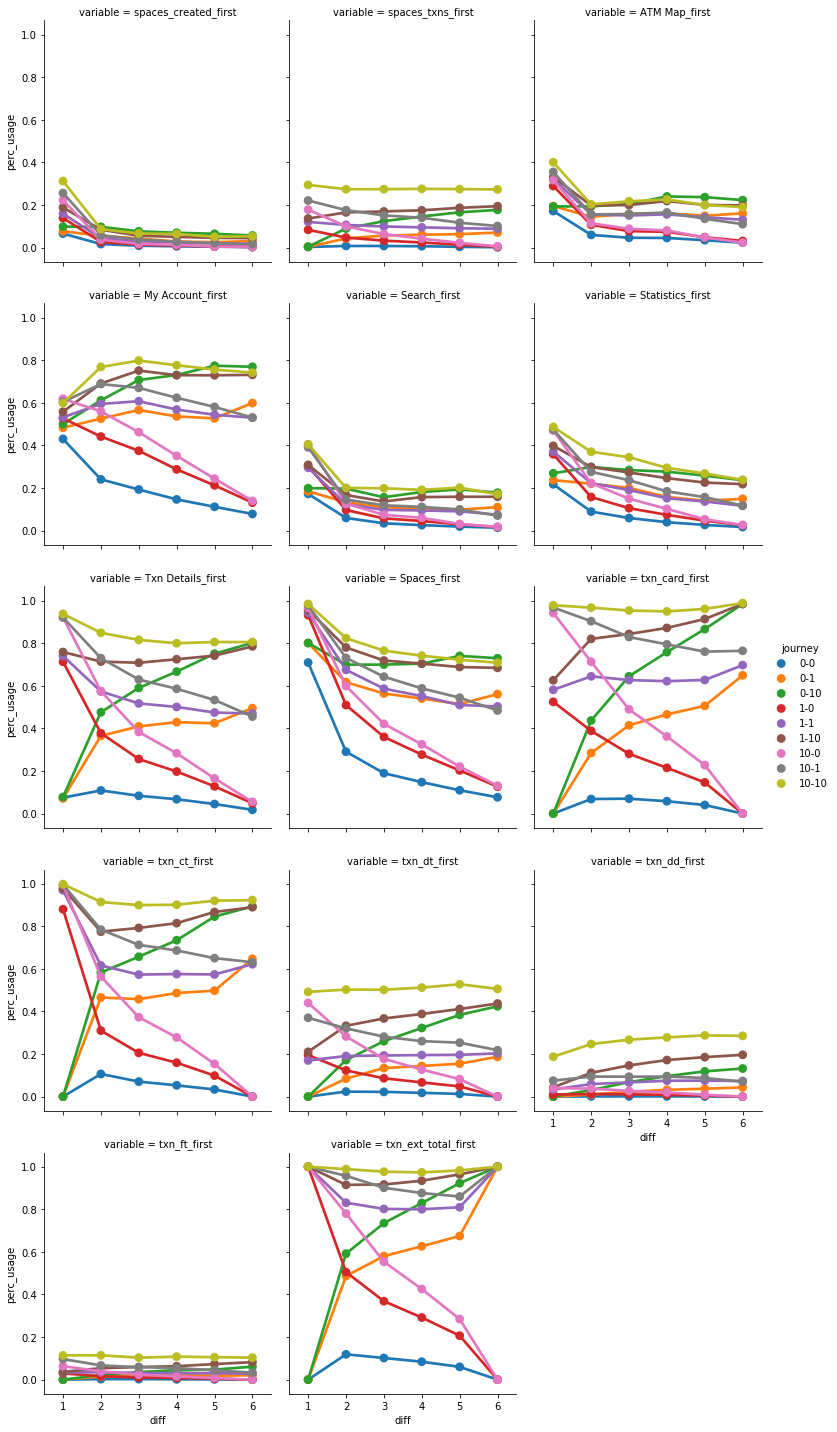

In [249]:
g = sns.catplot(
    x="diff",
    y="perc_usage",
    col="variable",
    hue="journey",
    data=df_e_ret_grp,
    kind="point",
    height=4,
    aspect=0.9,
    col_wrap=3,
)

In [252]:
pd.pivot_table(
    df_1[["user_created", "country", "early_power_user"]],
    columns=["early_power_user"],
    index=["country"],
    aggfunc=len,
)

user_created      
early_power_user            0     1
country                            
AUT                      2028   749
DEU                     19162  9191
ESP                      8197  1772
FRA                     23527  7838
GBR                     13110  4666
ITA                     22593  3378
NON-EUR                  2607   178
ROE                     11197  2355

In [253]:
pd.pivot_table(
    df_1[["user_created", "product_id", "early_power_user"]],
    columns=["early_power_user"],
    index=["product_id"],
    aggfunc=len,
)

user_created       
early_power_user                0      1
product_id                              
0                            1264    418
BLACK_CARD_MONTHLY           4654   2258
BUSINESS_BLACK               1594    459
BUSINESS_CARD                9403   2055
FLEX_ACCOUNT_MONTHLY         2055    908
METAL_CARD_MONTHLY           8036   2356
STANDARD                    75415  21673

Text(0, 0.5, '% KYCCs')

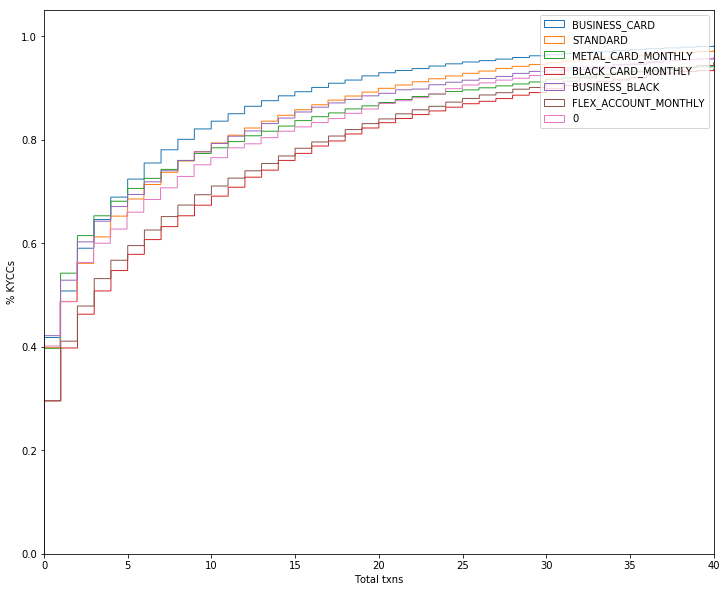

In [255]:
n_bins = 10000

fig, ax = plt.subplots(figsize=(12, 10))

# plot the cumulative histogram

for x in df_1["product_id"].unique():
    n, bins, patches = ax.hist(
        df_1["txn_ext_total"][df_1["product_id"] == x],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label=x,
    )

ax.legend()
plt.xlim((0, 40))
plt.xlabel("Total txns")
plt.ylabel("% KYCCs")

Text(0, 0.5, '% KYCCs')

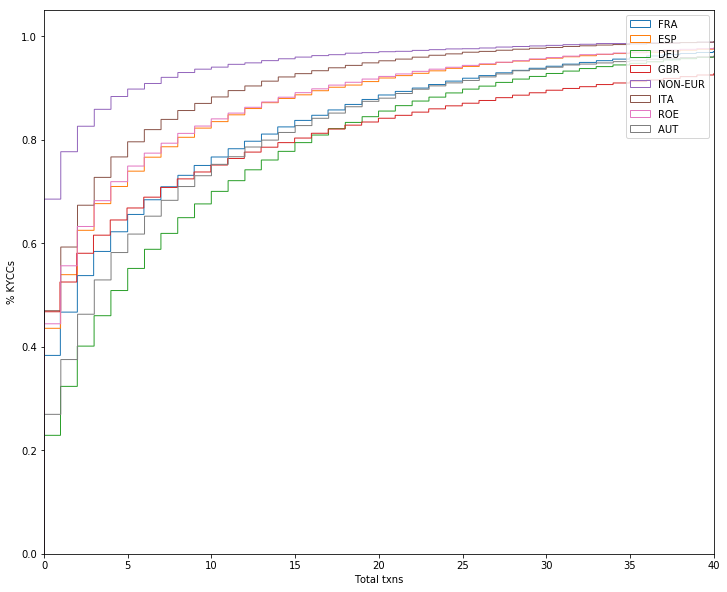

In [256]:
n_bins = 10000

fig, ax = plt.subplots(figsize=(12, 10))

# plot the cumulative histogram

for x in df_1["country"].unique():
    n, bins, patches = ax.hist(
        df_1["txn_ext_total"][df_1["country"] == x],
        n_bins,
        density=True,
        histtype="step",
        cumulative=True,
        label=x,
    )

ax.legend()
plt.xlim((0, 40))
plt.xlabel("Total txns")
plt.ylabel("% KYCCs")

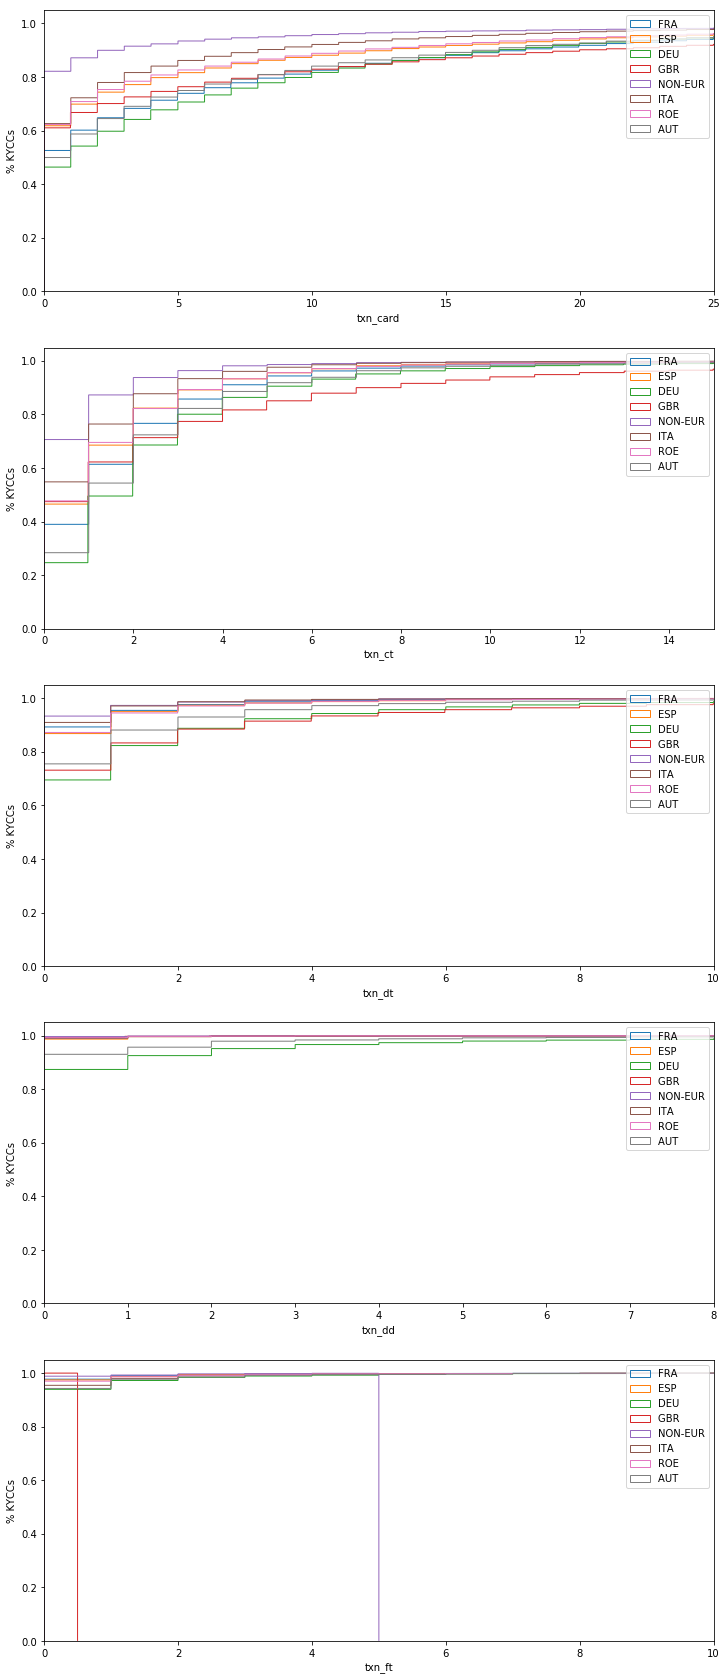

In [262]:
ls = {"txn_card": 25, "txn_ct": 15, "txn_dt": 10, "txn_dd": 8, "txn_ft": 10}

fig, ax = plt.subplots(len(ls), figsize=(12, 30))

# plot the cumulative histogram

for i, t in enumerate(ls):
    n_bins = 10000

    # plot the cumulative histogram

    for x in df_1["country"].unique():
        n, bins, patches = ax[i].hist(
            df_1[t][df_1["country"] == x],
            n_bins,
            density=True,
            histtype="step",
            cumulative=True,
            label=x,
        )
        ax[i].legend()
        ax[i].set_xlim((0, ls[t]))
        ax[i].set_xlabel(t)
        ax[i].set_ylabel("% KYCCs")

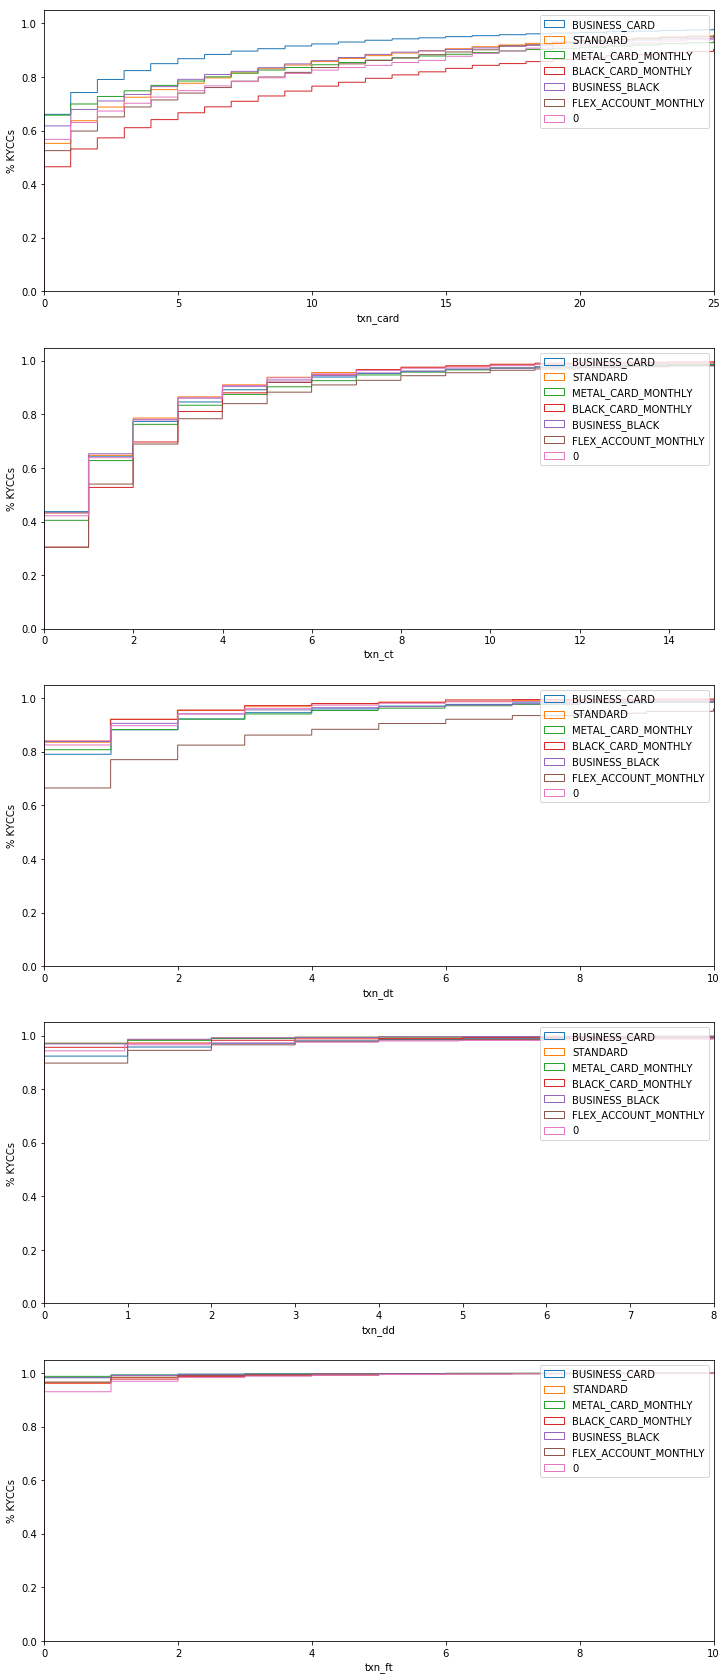

In [263]:
ls = {"txn_card": 25, "txn_ct": 15, "txn_dt": 10, "txn_dd": 8, "txn_ft": 10}

fig, ax = plt.subplots(len(ls), figsize=(12, 30))

# plot the cumulative histogram

for i, t in enumerate(ls):
    n_bins = 10000

    # plot the cumulative histogram

    for x in df_1["product_id"].unique():
        n, bins, patches = ax[i].hist(
            df_1[t][df_1["product_id"] == x],
            n_bins,
            density=True,
            histtype="step",
            cumulative=True,
            label=x,
        )
        ax[i].legend()
        ax[i].set_xlim((0, ls[t]))
        ax[i].set_xlabel(t)
        ax[i].set_ylabel("% KYCCs")

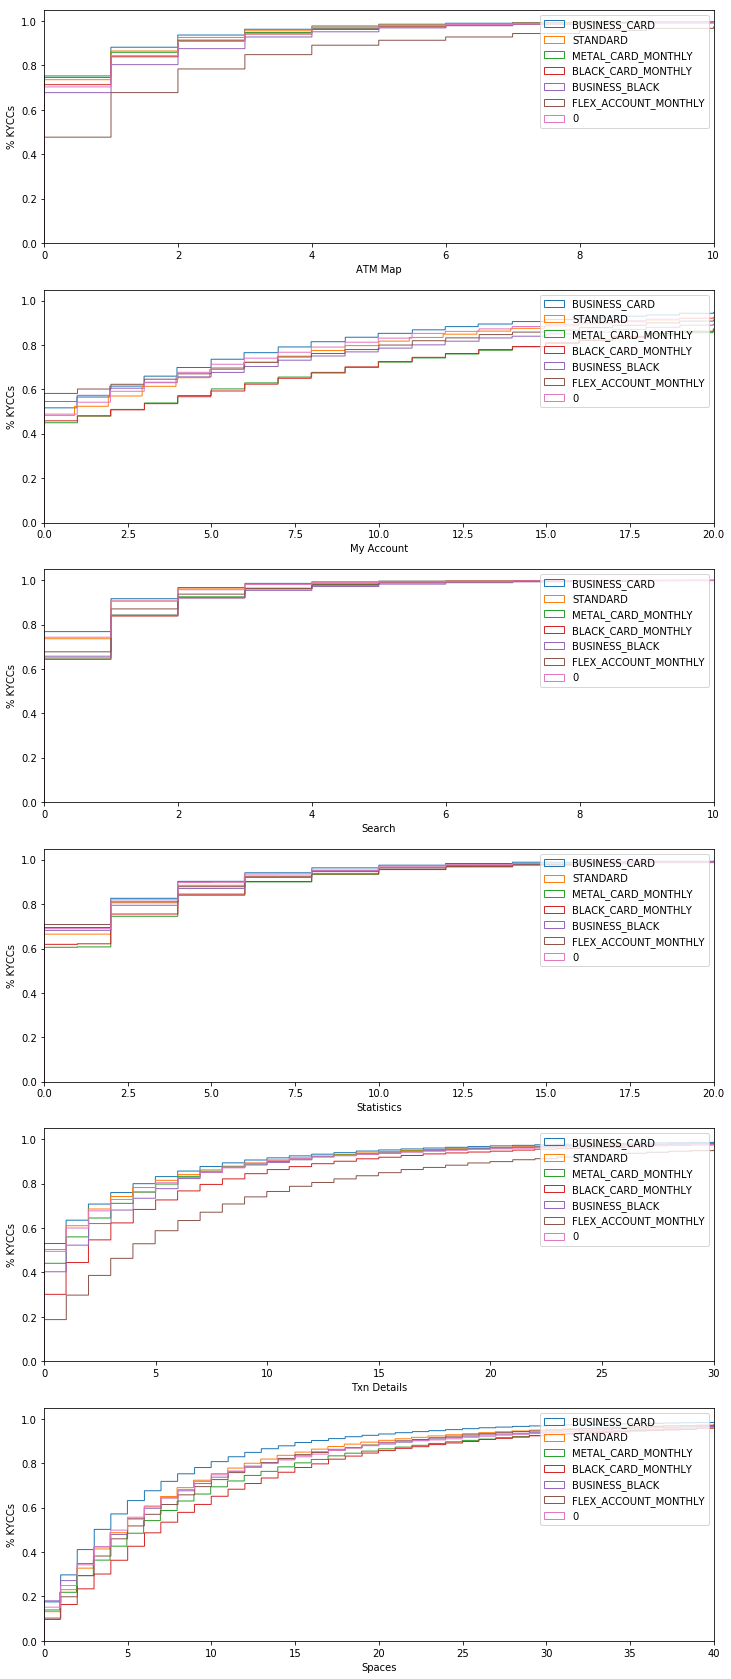

In [265]:
ls = {
    "ATM Map": 10,
    "My Account": 20,
    "Search": 10,
    "Statistics": 20,
    "Txn Details": 30,
    "Spaces": 40,
}

fig, ax = plt.subplots(len(ls), figsize=(12, 30))

# plot the cumulative histogram

for i, t in enumerate(ls):
    n_bins = 10000

    # plot the cumulative histogram

    for x in df_1["product_id"].unique():
        n, bins, patches = ax[i].hist(
            df_1[t][df_1["product_id"] == x],
            n_bins,
            density=True,
            histtype="step",
            cumulative=True,
            label=x,
        )
        ax[i].legend()
        ax[i].set_xlim((0, ls[t]))
        ax[i].set_xlabel(t)
        ax[i].set_ylabel("% KYCCs")

In [267]:
pd.pivot_table(
    df_1[["user_created", "product_id", "journey"]],
    columns=["journey"],
    index=["product_id"],
    aggfunc=len,
)

user_created                                              \
journey                       0-0   0-1  0-10    1-0    1-1  1-10  10-0  10-1   
product_id                                                                      
0                             523    90    62    236    195   158    88    81   
BLACK_CARD_MONTHLY           1700   177   166   1046    820   745   508   501   
BUSINESS_BLACK                746    67    52    364    206   159   137    80   
BUSINESS_CARD                3707   711   369   1801   1838   977   485   495   
FLEX_ACCOUNT_MONTHLY          715    75    85    579    308   293   260   154   
METAL_CARD_MONTHLY           3350   400   375   2178    915   818   673   450   
STANDARD                    31362  4378  2921  17573  11806  7375  6057  5304   

                             
journey               10-10  
product_id                   
0                       249  
BLACK_CARD_MONTHLY     1249  
BUSINESS_BLACK          242  
BUSINESS_CARD          1075  
FLEX_ACCOUNT_MONTHLY    494  
METAL_CARD_MONTHLY     1233  
STANDARD              10312

In [268]:
pd.pivot_table(
    df_1[["user_created", "country", "journey"]],
    columns=["journey"],
    index=["country"],
    aggfunc=len,
)

user_created                                                
journey          0-0   0-1  0-10   1-0   1-1  1-10  10-0  10-1 10-10
country                                                             
AUT              552   126    70   460   534   286   125   188   436
DEU             4382  1215   891  3996  4886  3792  1427  1907  5857
ESP             3698   407   237  2207  1107   541   604   481   687
FRA             9386  1437  1196  5254  3548  2706  2316  2009  3513
GBR             7104   653   554  3010  1014   775  2004   914  1748
ITA            10246  1328   620  5764  3185  1450   956   937  1485
NON-EUR         1719   119    70   406   183   110    58    50    70
ROE             5016   613   392  2680  1631   865   718   579  1058

In [270]:
pd.pivot_table(
    df_1[["user_created", "country", "early_group", "late_group"]],
    columns=["early_group", "late_group"],
    index=["country"],
    aggfunc=len,
)

user_created                                                
early_group            0                 1                10            
late_group             0     1    10     0     1    10     0     1    10
country                                                                 
AUT                  552   126    70   460   534   286   125   188   436
DEU                 4382  1215   891  3996  4886  3792  1427  1907  5857
ESP                 3698   407   237  2207  1107   541   604   481   687
FRA                 9386  1437  1196  5254  3548  2706  2316  2009  3513
GBR                 7104   653   554  3010  1014   775  2004   914  1748
ITA                10246  1328   620  5764  3185  1450   956   937  1485
NON-EUR             1719   119    70   406   183   110    58    50    70
ROE                 5016   613   392  2680  1631   865   718   579  1058

In [271]:
pd.pivot_table(
    df_1[["user_created", "product_id", "early_group", "late_group"]],
    columns=["early_group", "late_group"],
    index=["product_id"],
    aggfunc=len,
)

user_created                                              \
early_group                     0                  1                 10         
late_group                      0     1    10      0      1    10     0     1   
product_id                                                                      
0                             523    90    62    236    195   158    88    81   
BLACK_CARD_MONTHLY           1700   177   166   1046    820   745   508   501   
BUSINESS_BLACK                746    67    52    364    206   159   137    80   
BUSINESS_CARD                3707   711   369   1801   1838   977   485   495   
FLEX_ACCOUNT_MONTHLY          715    75    85    579    308   293   260   154   
METAL_CARD_MONTHLY           3350   400   375   2178    915   818   673   450   
STANDARD                    31362  4378  2921  17573  11806  7375  6057  5304   

                             
early_group                  
late_group               10  
product_id                   
0                       249  
BLACK_CARD_MONTHLY     1249  
BUSINESS_BLACK          242  
BUSINESS_CARD          1075  
FLEX_ACCOUNT_MONTHLY    494  
METAL_CARD_MONTHLY     1233  
STANDARD              10312

In [272]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132548 entries, 0 to 132547
Data columns (total 50 columns):
user_created        132548 non-null datetime64[ns]
kyc_c               132548 non-null datetime64[ns]
country             132548 non-null object
product_id          132548 non-null object
cohort              132548 non-null datetime64[ns]
diff                132548 non-null int64
txn_card            132548 non-null float64
txn_ct              132548 non-null float64
txn_dt              132548 non-null float64
txn_dd              132548 non-null float64
txn_ft              132548 non-null float64
txn_ext_total       132548 non-null float64
login_total         132548 non-null float64
login_web           132548 non-null float64
spaces_eod          132548 non-null float64
spaces_created      132548 non-null float64
spaces_deleted      132548 non-null float64
ATM Map             132548 non-null float64
Bal. Check          132548 non-null float64
Bal. Discreet       132548 non-null 

In [279]:
df_1.groupby("early_group")[e_list].median()

,spaces_created,spaces_txns,ATM Map,My Account,Search,Statistics,Txn Details,Spaces,txn_card,txn_ct,txn_dt,txn_dd,txn_ft,txn_ext_total
early_group,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,3.0
10,0.0,0.0,0.0,6.0,0.0,0.0,6.0,10.0,13.0,4.0,0.0,0.0,0.0,19.0


In [280]:
df_1.groupby("early_group")[e_list].mean()

,spaces_created,spaces_txns,ATM Map,My Account,Search,Statistics,Txn Details,Spaces,txn_card,txn_ct,txn_dt,txn_dd,txn_ft,txn_ext_total
early_group,,,,,,,,,,,,,,
0,0.088063,0.004036,0.324672,2.997578,0.265553,0.797736,0.186831,3.738002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.208811,0.309228,0.712562,6.460111,0.508474,1.830065,3.158861,9.132229,1.535404,1.654812,0.290494,0.036277,0.044652,3.605219
10,0.407276,1.617453,1.089090,11.478342,0.762406,3.957878,11.203007,16.900787,17.815282,4.982408,1.700070,0.426030,0.253560,25.392107


In [282]:
df_1["txn_ext_total_cap"] = np.where(
    df_1["txn_ext_total"] > 25, 26, df_1["txn_ext_total"]
)
df_1.groupby("txn_ext_total_cap")[e_list].median()

,spaces_created,spaces_txns,ATM Map,My Account,Search,Statistics,Txn Details,Spaces,txn_card,txn_ct,txn_dt,txn_dd,txn_ft,txn_ext_total
txn_ext_total_cap,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0
2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,2.0
3.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,6.0,1.0,2.0,0.0,0.0,0.0,3.0
4.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,7.0,2.0,2.0,0.0,0.0,0.0,4.0
5.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,7.0,2.0,2.0,0.0,0.0,0.0,5.0
6.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,8.0,3.0,2.0,0.0,0.0,0.0,6.0
7.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,8.0,4.0,2.0,0.0,0.0,0.0,7.0
8.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,8.0,5.0,2.0,0.0,0.0,0.0,8.0


In [339]:
df_p = (
    df_1.groupby("txn_ext_total_cap")[
        ["txn_card", "txn_ct", "txn_dt", "txn_dd", "txn_ft"]
    ]
    .mean()
    .reset_index()
)

In [340]:
df_p.head()

,txn_ext_total_cap,txn_card,txn_ct,txn_dt,txn_dd,txn_ft
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.102219,0.827021,0.050713,0.000555,0.006260
2,2.0,0.520020,1.256119,0.173579,0.010241,0.021608
3,3.0,1.051724,1.598155,0.245463,0.028584,0.039322
4,4.0,1.618679,1.887425,0.344507,0.037396,0.056578


Text(0, 0.5, '% txns (mean)')

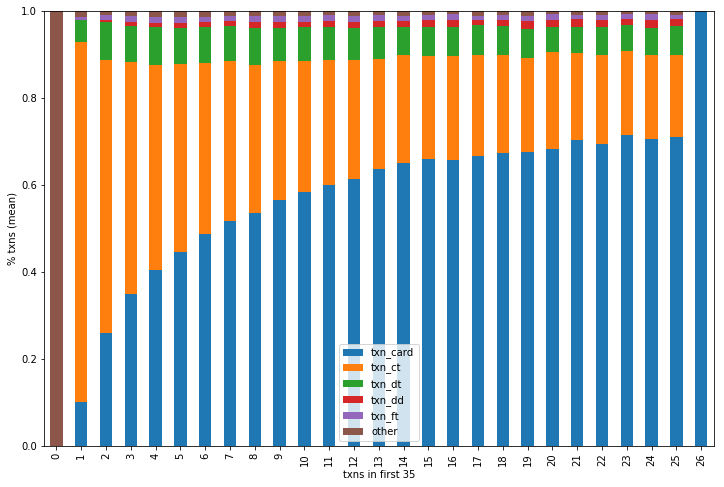

In [355]:
df_p = (
    df_1.groupby("txn_ext_total_cap")[
        ["txn_card", "txn_ct", "txn_dt", "txn_dd", "txn_ft"]
    ]
    .mean()
    .reset_index()
)
df_p = df_p.iloc[:, 1:].div(df_p.txn_ext_total_cap, axis=0)
df_p["other"] = 1 - df_p.iloc[:, :].sum(axis=1)

ax = df_p.plot(kind="bar", stacked=True, ylim=(0, 1), figsize=(12, 8))

ax.set_xlabel("txns in first 35")
ax.set_ylabel("% txns (mean)")

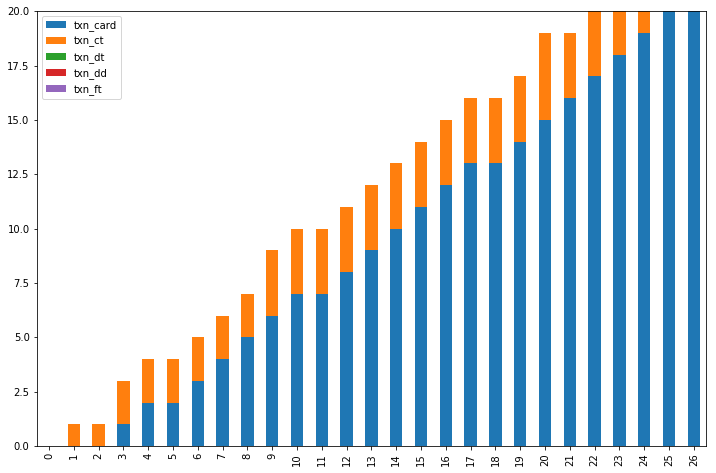

In [351]:
df_p = (
    df_1.groupby("txn_ext_total_cap")[
        ["txn_card", "txn_ct", "txn_dt", "txn_dd", "txn_ft"]
    ]
    .median()
    .reset_index()
)

df_p[["txn_card", "txn_ct", "txn_dt", "txn_dd", "txn_ft"]].plot(
    kind="bar", stacked=True, ylim=(0, 20), figsize=(12, 8)
)